In [1]:
import nbimporter
import numpy as np
from functools import lru_cache

# import section7_1_b as default
import s07_01_c_gas_boiler as gas
import s07_01_d_kerosene_boiler as oil
import s07_01_e_electric_heatpump as eheatpump
import s07_01_f_electric_heater as eheater
import s07_01_g_hybrid_hw_hybrid_ht_gas as hybrid_gas
import s07_01_h_hybrid_hw_gas_ht_hybrid as gas_hybrid
import s07_01_i_hybrid_hw_hybrid_ht_hybrid as whybrid
import s07_01_j_hot_water_saving_coefficient as watersaving
import s07_01_m_schedule_for_hot_water_use_and_bathing as schedule

import s09_02_water_based_solar_system as lss
import s09_03_air_based_solar_system as ass

from s11_01_external_condition import load_outdoor, get_Theta_ex
from s11_02_solar_radiation import load_solrad
from s11_03_life_schedule import load_schedule, get_schedule_hw

import copy
import matplotlib.pyplot as plt

# 第七章　給湯設備 / Chapter 7 Hot water supply system

## 第一節　給湯設備 / Section 1 Hot water supply system

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5. 給湯設備によるエネルギー消費量 / Energy consumption by hot water supply system

#### 5.1 消費電力量 / Power consumption

台所、洗面所及び浴室等がいずれも無い場合は0とする。 

If there is no kitchen, bathroom, bathroom, etc., it will be 0.

$$\large
\displaystyle E_{E,W,d,t} = E_{E,hs,d,t} + E_{E,aux,ss,d,t}
$$

$ E_{E,W,d,t} $：日付$d$の時刻$t$における 1時間当たりの給湯設備の消費電力量 (kWh/h) / Electric power consumption of water heater per hour at time $ t $ of date $ d $  
$ E_{E,aux,ss,d,t} $：日付$d$の時刻$t$における 1時間当たりの太陽熱利用設備の補機の消費電力量 (kWh/h) / Power consumption of auxiliary solar energy equipment per hour at time $ t $ on date $ d $    
$ E_{E,hs,d,t} $：日付$d$の時刻$t$における1時間当たりの給湯機（給湯温水暖房機における給湯部も含む。以下、同じ。）の消費電力量 (kWh/h) / Power consumption of the water heater per hour (including the hot water supply unit in the hot water supply water heater) at the time $ t $ of the date $ d $  

日付$d$の時刻$t$における1時間当たりの太陽熱利用設備の補機の消費電力量$ E_{E,aux,ss,d,t} $は、液体集熱式太陽熱利用設備及び空気集熱式太陽熱利用設備のどちらも採用しない場合、ゼロとする。

The energy consumption $ E_{E,aux,ss,d,t} $ of the auxiliary equipment of the solar utilization equipment per hour at the time $ t $ of the date $ d $ is the liquid collection solar utilization equipment & air collection When neither of thermal solar utilization equipment is adopted, it shall be zero.

In [2]:
@lru_cache()
def calc_hotwater_load(n_p, region, sol_region, has_bath, bath_function, pipe_diameter, kitchen_watersaving_A,
                      kitchen_watersaving_C, shower_watersaving_A, shower_watersaving_B, washbowl_watersaving_C,
                      bath_insulation,
                      type=None, ls_type=None, A_sp=None, P_alpha_sp=None, P_beta_sp=None, W_tnk_ss=None,
                      hotwater_use=None, heating_flag_d=None, A_col=None, P_alpha=None, P_beta=None, V_fan_P0=None,
                      d0=None, d1=None, m_fan_test=None, W_tnk_ass=None
                      ):
    """給湯負荷の計算

    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param sol_region: 年間の日射地域区分(1-5)
    :type sol_region: int
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :param bath_function: ふろ機能の種類
    :type bath_function: str
    :param pipe_diameter: ヘッダー分岐後の径
    :type pipe_diameter: str
    :param kitchen_watersaving_A: 台所水栓の手元止水機能の有無
    :type kitchen_watersaving_A: bool
    :param kitchen_watersaving_C: 台所水栓の水優先吐水機能の有無
    :type kitchen_watersaving_C: bool
    :param shower_watersaving_A: 浴室シャワー水栓の手元止水機能の有無
    :type shower_watersaving_A: bool
    :param shower_watersaving_B: 浴室シャワー水栓の小流量吐水機能の有無
    :type shower_watersaving_B: bool
    :param washbowl_watersaving_C: 洗面水栓の水優先吐水機能の有無
    :type washbowl_watersaving_C: bool
    :param bath_insulation: 浴槽の断熱の有無
    :type bath_insulation: bool
    :param type: 太陽熱利用設備の種類 (液体集熱式,空気集熱式,None)
    :type type: str
    :param ls_type: 液体集熱式太陽熱利用設備の種類 (太陽熱温水器,ソーラーシステム)
    :type ls_type: str
    :param A_sp: 太陽熱集熱部の有効集熱面積 (m2)
    :type A_sp: float
    :param P_alpha_sp: 太陽熱集熱部の方位角 (°)
    :type P_alpha_sp: float
    :param P_beta_sp: 太陽熱集熱部の傾斜角 (°)
    :type P_beta_sp: float
    :param W_tnk_ss: ソーラーシステムのタンク容量 (L)
    :type W_tnk_ss: float
    :param hotwater_use: 空気集熱式太陽熱利用設備が給湯部を有する場合はTrue
    :type hotwater_use: bool
    :param heating_flag_d: 暖房日
    :type heating_flag_d:　ndarray
    :param A_col: 集熱器群の面積 (m2)
    :type A_col: tuple
    :param P_alpha: 方位角 (°)
    :type P_alpha: float
    :param P_beta:傾斜角 (°)
    :type P_beta: float
    :param V_fan_P0: 空気搬送ファンの送風機特性曲線において機外静圧をゼロとしたときの空気搬送ファンの風量 (m3/h)
    :type V_fan_P0: float
    :param d0: 集熱器群を構成する集熱器の集熱効率特性線図一次近似式の切片 (-)
    :type d0: tuple
    :param d1: 集熱器群を構成する集熱器の集熱効率特性線図一次近似式の傾き (W/(m2K))
    :type d1: tuple
    :param m_fan_test: 集熱器群を構成する集熱器の集熱性能試験時における単位面積当たりの空気の質量流量 (kg/(s・m2))
    :type m_fan_test: tuple
    :param W_tnk_ass: タンク容量 (L)
    :type W_tnk_ass: float
    :return: 1日当たりの給湯設備付加
    :rtype: dict
    """


    # 生活スケジュール
    schedule = load_schedule()
    schedule_hw = get_schedule_hw(schedule)

    # 外部環境
    outdoor = load_outdoor()
    Theta_ex_d_t = get_Theta_ex(region, outdoor)

    # ----- 14. 夜間平均外気温度 -----

    # 夜間平均外気温度 (℃) (15)
    Theta_ex_Nave_d = get_Theta_ex_Nave_d(Theta_ex_d_t)

    # ----- 13. 日平均外気温度 -----

    # 日平均外気温度 (℃) (14)
    Theta_ex_Ave_d = get_Theta_ex_Ave_d(Theta_ex_d_t)

    # ----- 12. 日平均給水温度 -----

    # 期間平均外気温度 (℃) (13)
    Theta_ex_prd_Ave_d = get_Theta_ex_prd_Ave_d(Theta_ex_Ave_d)

    # 日平均給水温度 (℃) (12)
    Theta_wtr_d = get_Theta_wtr_d(region, Theta_ex_prd_Ave_d)

    # ----- 11. 浴槽沸かし直しによる給湯熱負荷 -----

    # 浴槽沸かし直しによる給湯熱負荷 (MJ/h) (10)
    L_ba_d_t = calc_L_ba_d_t(bath_insulation, schedule_hw, has_bath, Theta_ex_Ave_d, n_p)

    # ----- 10. 基準給湯量 -----

    # 基準給湯量 (L/h) (7)
    W_k_d_t = calc_W_k_d_t(n_p, schedule_hw)
    W_s_d_t = calc_W_s_d_t(n_p, schedule_hw, has_bath)
    W_w_d_t = calc_W_w_d_t(n_p, schedule_hw)
    W_b1_d_t = calc_W_b1_d_t(n_p, schedule_hw, has_bath, bath_function)
    W_b2_d_t = calc_W_b2_d_t(n_p, schedule_hw, has_bath, bath_function)

    # 浴槽水栓さし湯時における基準給湯量 (L/h) (9)
    W_ba1_d_t = calc_W_ba1_d_t(bath_function, L_ba_d_t, Theta_wtr_d)

    # ----- 9. 節湯補正給湯量 -----

    # 節湯補正給湯量 (L/h) (6)
    W_dash_k_d_t = calc_W_dash_k_d_t(W_k_d_t, kitchen_watersaving_A, kitchen_watersaving_C, pipe_diameter, Theta_wtr_d)
    W_dash_s_d_t = calc_W_dash_s_d_t(W_s_d_t, shower_watersaving_A, shower_watersaving_B, pipe_diameter)
    W_dash_w_d_t = calc_W_dash_w_d_t(W_w_d_t, washbowl_watersaving_C, pipe_diameter, Theta_wtr_d)
    W_dash_b1_d_t = calc_W_dash_b1_d_t(W_b1_d_t, pipe_diameter)
    W_dash_b2_d_t = calc_W_dash_b2_d_t(W_b2_d_t)
    W_dash_ba1_d_t = calc_W_dash_ba1_d_t(W_ba1_d_t, pipe_diameter)

    # ----- 8. 節湯補正給湯熱負荷 -----

    # 基準給湯温度 (℃)
    Theta_sw_k = get_Theta_sw_k()
    Theta_sw_s = get_Theta_sw_s()
    Theta_sw_w = get_Theta_sw_w()

    # 節湯補正給湯熱負荷 (MJ/h) (5)
    L_dash_k_d_t = get_L_dash_k_d_t(W_dash_k_d_t, Theta_sw_k, Theta_wtr_d)
    L_dash_s_d_t = get_L_dash_s_d_t(W_dash_s_d_t, Theta_sw_s, Theta_wtr_d)
    L_dash_w_d_t = get_L_dash_w_d_t(W_dash_w_d_t, Theta_sw_w, Theta_wtr_d)
    L_dash_b1_d_t, L_dash_b2_d_t = get_L_dash_bx_d_t(W_dash_b1_d_t, W_dash_b2_d_t, Theta_wtr_d, has_bath, bath_function)
    L_dash_ba1_d_t, L_dash_ba2_d_t = get_L_dash_bax_d_t(W_dash_ba1_d_t, Theta_wtr_d, L_ba_d_t, has_bath, bath_function)

    # ----- 7. 太陽熱補正給湯熱負荷 -----

    # 太陽熱利用給湯設備による補正集熱量
    L_sun_d_t = calc_L_sun_d_t(
        region=region,
        sol_region=sol_region,
        solar_device=type,
        ls_type=ls_type,
        A_sp=A_sp,
        P_alpha_sp=P_alpha_sp,
        P_beta_sp=P_beta_sp,
        W_tnk_ss=W_tnk_ss,
        hotwater_use=hotwater_use,
        heating_flag_d=heating_flag_d,
        A_col=A_col,
        P_alpha=P_alpha,
        P_beta=P_beta,
        V_fan_P0=V_fan_P0,
        d0=d0,
        d1=d1,
        m_fan_test=m_fan_test,
        W_tnk_ass=W_tnk_ass,
        Theta_wtr_d=Theta_wtr_d,
        L_dash_k_d_t=L_dash_k_d_t,
        L_dash_s_d_t=L_dash_s_d_t,
        L_dash_w_d_t=L_dash_w_d_t,
        L_dash_b1_d_t=L_dash_b1_d_t,
        L_dash_b2_d_t=L_dash_b2_d_t,
        L_dash_ba1_d_t=L_dash_ba1_d_t
    )

    # 太陽熱補正給湯熱負荷
    L_dashdash_k_d_t = calc_L_dashdash_k_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t,
                                            L_dash_ba1_d_t,
                                            L_sun_d_t)
    L_dashdash_s_d_t = calc_L_dashdash_s_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t,
                                            L_dash_ba1_d_t,
                                            L_sun_d_t)
    L_dashdash_w_d_t = calc_L_dashdash_w_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t,
                                            L_dash_ba1_d_t,
                                            L_sun_d_t)
    L_dashdash_b1_d_t = calc_L_dashdash_b1_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t,
                                              L_dash_ba1_d_t, L_sun_d_t)
    L_dashdash_b2_d_t = calc_L_dashdash_b2_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t,
                                              L_dash_ba1_d_t, L_sun_d_t)
    L_dashdash_ba1_d_t = calc_L_dashdash_ba1_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t,
                                                L_dash_ba1_d_t, L_sun_d_t)
    L_dashdash_ba2_d_t = get_L_dashdash_ba2_d_t(L_dash_ba2_d_t)
    
    """
    print('L_ba = {}'.format(np.sum(L_ba_d_t)))

    print('W_k = {}'.format(np.sum(W_k_d_t)))
    print('W_s = {}'.format(np.sum(W_s_d_t)))
    print('W_w = {}'.format(np.sum(W_w_d_t)))
    print('W_b1 = {}'.format(np.sum(W_b1_d_t)))
    print('W_b2 = {}'.format(np.sum(W_b2_d_t)))
    print('W_ba1 = {}'.format(np.sum(W_ba1_d_t)))

    print('W_dash_k = {}'.format(np.sum(W_dash_k_d_t)))
    print('W_dash_s = {}'.format(np.sum(W_dash_s_d_t)))
    print('W_dash_w = {}'.format(np.sum(W_dash_w_d_t)))
    print('W_dash_b1 = {}'.format(np.sum(W_dash_b1_d_t)))
    print('W_dash_b2 = {}'.format(np.sum(W_dash_b2_d_t)))
    print('W_dash_ba1 = {}'.format(np.sum(W_dash_ba1_d_t)))

    print('L_dash_k = {}'.format(np.sum(L_dash_k_d_t)))
    print('L_dash_s = {}'.format(np.sum(L_dash_s_d_t)))
    print('L_dash_w = {}'.format(np.sum(L_dash_w_d_t)))
    print('L_dash_b1 = {}'.format(np.sum(L_dash_b1_d_t)))
    print('L_dash_b2 = {}'.format(np.sum(L_dash_b2_d_t)))
    print('L_dash_ba1 = {}'.format(np.sum(L_dash_ba1_d_t)))
    print('L_dash_ba2 = {}'.format(np.sum(L_dash_ba2_d_t)))

    print('L_dashdash_k = {}'.format(np.sum(L_dashdash_k_d_t)))
    print('L_dashdash_s = {}'.format(np.sum(L_dashdash_s_d_t)))
    print('L_dashdash_w = {}'.format(np.sum(L_dashdash_w_d_t)))
    print('L_dashdash_b1 = {}'.format(np.sum(L_dashdash_b1_d_t)))
    print('L_dashdash_b2 = {}'.format(np.sum(L_dashdash_b2_d_t)))
    print('L_dashdash_ba1 = {}'.format(np.sum(L_dashdash_ba1_d_t)))
    print('L_dashdash_ba2 = {}'.format(np.sum(L_dashdash_ba2_d_t)))
    """
    
    return {
        'L_dash_k_d_t': L_dash_k_d_t,
        'L_dash_s_d_t': L_dash_s_d_t,
        'L_dash_w_d_t': L_dash_w_d_t,
        'L_dash_b1_d_t': L_dash_b1_d_t,
        'L_dash_b2_d_t': L_dash_b2_d_t,
        'L_dash_ba1_d_t': L_dash_ba1_d_t,
        'L_dash_ba2_d_t': L_dash_ba2_d_t,
        'L_dashdash_k_d_t': L_dashdash_k_d_t,
        'L_dashdash_s_d_t': L_dashdash_s_d_t,
        'L_dashdash_w_d_t': L_dashdash_w_d_t,
        'L_dashdash_b1_d_t': L_dashdash_b1_d_t,
        'L_dashdash_b2_d_t': L_dashdash_b2_d_t,
        'L_dashdash_ba1_d_t': L_dashdash_ba1_d_t,
        'L_dashdash_ba2_d_t': L_dashdash_ba2_d_t,
        'W_dash_k_d_t': W_dash_k_d_t,
        'W_dash_s_d_t': W_dash_s_d_t,
        'W_dash_w_d_t': W_dash_w_d_t,
        'W_dash_b1_d_t': W_dash_b1_d_t,
        'W_dash_b2_d_t': W_dash_b2_d_t,
        'W_dash_ba1_d_t': W_dash_ba1_d_t,
        'Theta_ex_Ave_d': Theta_ex_Ave_d,
        'Theta_ex_Nave_d': Theta_ex_Nave_d
    }


In [3]:
def calc_E_E_W_d_t(n_p, L_HWH, heating_flag_d, region, sol_region, HW, SHC):
    """1時間当たりの給湯設備の消費電力量 (1)

    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param L_HWH: 温水暖房用熱源機の熱負荷
    :type L_HWH: ndarray
    :param heating_flag_d: 暖房日
    :type heating_flag_d: ndarray
    :param region: 省エネルギー地域区分
    :type region: int
    :param sol_region: 年間の日射地域区分(1-5)
    :type sol_region: int
    :param HW: 給湯機の仕様
    :type HW: dict
    :param SHC: 集熱式太陽熱利用設備の仕様
    :type SHC: dict
    :return: 1日当たりの給湯設備の消費電力量 (kWh/d)
    :rtype: ndarray
    """
    if HW is None or HW['hw_type'] is None:
        # 台所、洗面所及 び浴室等がいずれも無い場合は0とする
        return np.zeros(24 * 365)

    if HW['hw_type'] == 'コージェネレーションを使用する':
        return np.zeros(24 * 365)

    # ふろ機能の修正
    bath_function = get_normalized_bath_function(HW['hw_type'], HW['bath_function'])

    # 給湯負荷の生成
    args = {
        'n_p': n_p,
        'region': region,
        'sol_region': sol_region,
        'has_bath': HW['has_bath'],
        'bath_function': bath_function,
        'pipe_diameter': HW['pipe_diameter'],
        'kitchen_watersaving_A': HW['kitchen_watersaving_A'],
        'kitchen_watersaving_C': HW['kitchen_watersaving_C'],
        'shower_watersaving_A': HW['shower_watersaving_A'],
        'shower_watersaving_B': HW['shower_watersaving_B'],
        'washbowl_watersaving_C': HW['washbowl_watersaving_C'],
        'bath_insulation': HW['bath_insulation']
    }
    if SHC is not None:
        if SHC['type'] == '液体集熱式':
            args.update({
                'type': SHC['type'],
                'ls_type': SHC['ls_type'],
                'A_sp': SHC['A_sp'],
                'P_alpha_sp': SHC['P_alpha_sp'],
                'P_beta_sp': SHC['P_beta_sp'],
                'W_tnk_ss': SHC['W_tnk_ss']
            })
        elif SHC['type'] == '空気集熱式':
            args.update({
                'type': SHC['type'],
                'hotwater_use': SHC['hotwater_use'],
                'heating_flag_d': tuple(heating_flag_d),
                'A_col': SHC['A_col'],
                'P_alpha': SHC['P_alpha'],
                'P_beta': SHC['P_beta'],
                'V_fan_P0': SHC['V_fan_P0'],
                'm_fan_test': SHC['m_fan_test'],
                'd0': SHC['d0'],
                'd1': SHC['d1'],
                'W_tnk_ass': SHC['W_tnk_ass']
            })
        else:
            raise ValueError(SHC['type'])

    hotwater_load = calc_hotwater_load(**args)

    # 1時間当たりの給湯機の消費電力量 (kWh/h)
    E_E_hs_d_t = calc_E_E_hs_d_t(
        hw_type=HW['hw_type'],
        bath_function=bath_function,
        hybrid_category=HW['hybrid_category'],
        package_id=HW['package_id'] if 'package_id' in HW else None,
        e_rtd=HW['e_rtd'],
        e_dash_rtd=HW['e_dash_rtd'],
        m1see=HW['m1see'] if 'm1see' in HW else None,
        L_dashdash_k_d_t=hotwater_load['L_dashdash_k_d_t'],
        L_dashdash_s_d_t=hotwater_load['L_dashdash_s_d_t'],
        L_dashdash_w_d_t=hotwater_load['L_dashdash_w_d_t'],
        L_dashdash_b1_d_t=hotwater_load['L_dashdash_b1_d_t'],
        L_dashdash_b2_d_t=hotwater_load['L_dashdash_b2_d_t'],
        L_dashdash_ba1_d_t=hotwater_load['L_dashdash_ba1_d_t'],
        L_dashdash_ba2_d_t=hotwater_load['L_dashdash_ba2_d_t'],
        W_dash_k_d_t=hotwater_load['W_dash_k_d_t'],
        W_dash_s_d_t=hotwater_load['W_dash_s_d_t'],
        W_dash_w_d_t=hotwater_load['W_dash_w_d_t'],
        W_dash_b1_d_t=hotwater_load['W_dash_b1_d_t'],
        W_dash_b2_d_t=hotwater_load['W_dash_b2_d_t'],
        W_dash_ba1_d_t=hotwater_load['W_dash_ba1_d_t'],
        Theta_ex_Ave_d=hotwater_load['Theta_ex_Ave_d'],
        Theta_ex_Nave_d=hotwater_load['Theta_ex_Nave_d'],
        L_HWH=L_HWH
    )

    # 太陽利用設備の補機の消費電力量
    E_E_aux_ss_d_t = calc_E_E_aux_ss_d_t(
        SHC=SHC,
        region=region,
        sol_region=sol_region,
        heating_flag_d=heating_flag_d
    )

    # 1時間当たりの給湯設備の消費電力量(1)
    E_E_W_d_t = E_E_hs_d_t + E_E_aux_ss_d_t

    return E_E_W_d_t


def calc_E_E_aux_ss_d_t(SHC, region=None, sol_region=None, heating_flag_d=None):
    """1時間当たりの補機の消費電力量 (kWh/h)

    :param SHC: 太陽熱利用設備の仕様
    :type SHC: dict
    :param region: 省エネルギー地域区分
    :type region: int
    :param sol_region: 年間の日射地域区分
    :type sol_region: int
    :param heating_flag_d: 暖房日
    :type heating_flag_d: ndarray
    :return: 1時間当たりの補機の消費電力量 (kWh/h)
    :rtype: ndarray
    """
    if SHC is None:
        return np.zeros(24 * 365)
    elif SHC['type'] == '液体集熱式':
        # 第九章「自然エネルギー利用設備」第二節「液体集熱式太陽熱利用設備」の算定方法により定まる
        # 1時間当たりの補機の消費電力量 (kWh/h)
        return lss.calc_E_E_lss_aux_d_t(
            ls_type=SHC['ls_type'],
            pmp_type='上記以外の機種',
            P_alpha_sp=SHC['P_alpha_sp'],
            P_beta_sp=SHC['P_beta_sp'],
            region=region,
            sol_region=sol_region
        )
    elif SHC['type'] == '空気集熱式':
        # 第九章「自然エネルギー利用設備」第三節「空気集熱式太陽熱利用設備」の算定方法により定まる
        # 1時間当たりの補機の消費電力量のうちの給湯設備への付加分 (kWh/h)
        return ass.calc_E_E_W_aux_ass_d_t(
            hotwater_use=SHC['hotwater_use'],
            heating_flag_d=heating_flag_d,
            region=region,
            sol_region=sol_region,
            P_alpha=SHC['P_alpha'],
            P_beta=SHC['P_beta'],
            A_col=SHC['A_col'],
            V_fan_P0=SHC['V_fan_P0'],
            m_fan_test=SHC['m_fan_test'],
            d0=SHC['d0'],
            d1=SHC['d1'],
            fan_sso=SHC['fan_sso'],
            fan_type=SHC['fan_type'],
            pump_sso=SHC['pump_sso']
        )
    else:
        raise ValueError(SHC['type'])


#### 5.2 ガス消費量 / Gas consumption

台所、洗面所及び浴室等がいずれも無い場合は0とする。 

If there is no kitchen, bathroom, bathroom, etc., it will be 0.

$$\large
\displaystyle E_{G,W,d,t} = E_{G,hs,d,t}
$$

$ E_{G,W,d,t} $：日付$d$の時刻$t$における1時間当たりの給湯設備のガス消費量 (MJ/h) / Gas consumption of water heater per hour at time $ t $ on date $ d $  
$ E_{G,hs,d,t} $：日付$d$の時刻$t$における1時間当たりの給湯機のガス消費量 (MJ/h) / Gas consumption of water heater per hour at time $ t $ on date $ d $  

In [4]:
def calc_E_G_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC):
    """1時間当たりの給湯設備のガス消費量 (MJ/h) (2)

    :param n_p: 仮想居住人数
    :type n_p: float
    :param L_HWH: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH: ndarray
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param region: 地域区分
    :type region: int
    :param sol_region: 年間の日射地域区分
    :type sol_region: int
    :param HW: 給湯機の仕様
    :type HW: dict
    :param SHC: 集熱式太陽熱利用設備の仕様
    :type SHC: dict
    :return: 1時間当たりの給湯設備のガス消費量 (MJ/h)
    :rtype: ndarray
    """
    if HW is None or HW['hw_type'] is None:
        # 台所、洗面所及 び浴室等がいずれも無い場合は0とする
        return np.zeros(24 * 365)

    # ふろ機能の修正
    bath_function = get_normalized_bath_function(HW['hw_type'], HW['bath_function'])

    # 給湯負荷の生成
    args = {
        'n_p': n_p,
        'region': region,
        'sol_region': sol_region,
        'has_bath': HW['has_bath'],
        'bath_function': bath_function,
        'pipe_diameter': HW['pipe_diameter'],
        'kitchen_watersaving_A': HW['kitchen_watersaving_A'],
        'kitchen_watersaving_C': HW['kitchen_watersaving_C'],
        'shower_watersaving_A': HW['shower_watersaving_A'],
        'shower_watersaving_B': HW['shower_watersaving_B'],
        'washbowl_watersaving_C': HW['washbowl_watersaving_C'],
        'bath_insulation': HW['bath_insulation']
    }
    if SHC is not None:
        if SHC['type'] == '液体集熱式':
            args.update({
                'type': SHC['type'],
                'ls_type': SHC['ls_type'],
                'A_sp': SHC['A_sp'],
                'P_alpha_sp': SHC['P_alpha_sp'],
                'P_beta_sp': SHC['P_beta_sp'],
                'W_tnk_ss': SHC['W_tnk_ss']
            })
        elif SHC['type'] == '空気集熱式':
            args.update({
                'type': SHC['type'],
                'hotwater_use': SHC['hotwater_use'],
                'heating_flag_d': tuple(heating_flag_d),
                'A_col': SHC['A_col'],
                'P_alpha': SHC['P_alpha'],
                'P_beta': SHC['P_beta'],
                'V_fan_P0': SHC['V_fan_P0'],
                'm_fan_test': SHC['m_fan_test'],
                'd0': SHC['d0'],
                'd1': SHC['d1'],
                'W_tnk_ass': SHC['W_tnk_ass']
            })
        else:
            raise ValueError(SHC['type'])

    hotwater_load = calc_hotwater_load(**args)

    # 1日当たりの給湯機のガス消費量
    E_G_hs_d = calc_E_G_hs_d(
        hw_type=HW['hw_type'],
        hybrid_category=HW['hybrid_category'],
        e_rtd=HW['e_rtd'],
        e_dash_rtd=HW['e_dash_rtd'],
        bath_function=bath_function,
        package_id=HW['package_id'] if 'package_id' in HW else None,
        L_dashdash_k_d_t=hotwater_load['L_dashdash_k_d_t'],
        L_dashdash_s_d_t=hotwater_load['L_dashdash_s_d_t'],
        L_dashdash_w_d_t=hotwater_load['L_dashdash_w_d_t'],
        L_dashdash_b1_d_t=hotwater_load['L_dashdash_b1_d_t'],
        L_dashdash_b2_d_t=hotwater_load['L_dashdash_b2_d_t'],
        L_dashdash_ba1_d_t=hotwater_load['L_dashdash_ba1_d_t'],
        L_dashdash_ba2_d_t=hotwater_load['L_dashdash_ba2_d_t'],
        W_dash_k_d_t=hotwater_load['W_dash_k_d_t'],
        W_dash_s_d_t=hotwater_load['W_dash_s_d_t'],
        W_dash_w_d_t=hotwater_load['W_dash_w_d_t'],
        W_dash_b1_d_t=hotwater_load['W_dash_b1_d_t'],
        W_dash_b2_d_t=hotwater_load['W_dash_b2_d_t'],
        W_dash_ba1_d_t=hotwater_load['W_dash_ba1_d_t'],
        Theta_ex_Ave=hotwater_load['Theta_ex_Ave_d'],
        Theta_ex_Nave=hotwater_load['Theta_ex_Nave_d'],
        L_HWH=L_HWH
    )

    return E_G_hs_d


#### 5.3 灯油消費量 / Kerosene consumption

台所、洗面所及び浴室等がいずれも無い場合は0とする。 

If there is no kitchen, bathroom, bathroom, etc., it will be 0.

$$\large
\displaystyle E_{K,W,d,t} = E_{K,hs,d,t}
$$

$ E_{K,W,d,t} $：日付$d$の時刻$t$における1時間当たりの給湯設備の灯油消費量 (MJ/h) / Consumption of kerosene in water heater per hour at time $ t $ on date $ d $  
$ E_{K,hs,d,t} $：日付$d$の時刻$t$における1時間当たりの給湯機の灯油消費量 (MJ/h) / Water heater kerosene consumption per hour at time $ t $ on date $ d $  

In [5]:
def calc_E_K_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC):
    """1時間当たりの給湯設備の灯油消費量 (MJ/h) (3)

    :param n_p: 仮想居住人数
    :type n_p: float
    :param L_HWH: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH: ndarray
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param sol_region: 年間の日射地域区分
    :type sol_region: int
    :param HW: 給湯機の仕様
    :type HW: dict
    :param SHC: 集熱式太陽熱利用設備の仕様
    :type SHC: dict
    :return: 1時間当たりの給湯設備の灯油消費量 (MJ/h) (3)
    :rtype: ndarray
    """
    if HW is None or HW['hw_type'] is None:
        # 台所、洗面所及 び浴室等がいずれも無い場合は0とする
        return np.zeros(24 * 365)

    # ふろ機能の修正
    bath_function = get_normalized_bath_function(HW['hw_type'], HW['bath_function'])

    # 給湯負荷の生成
    args = {
        'n_p': n_p,
        'region': region,
        'sol_region': sol_region,
        'has_bath': HW['has_bath'],
        'bath_function': bath_function,
        'pipe_diameter': HW['pipe_diameter'],
        'kitchen_watersaving_A': HW['kitchen_watersaving_A'],
        'kitchen_watersaving_C': HW['kitchen_watersaving_C'],
        'shower_watersaving_A': HW['shower_watersaving_A'],
        'shower_watersaving_B': HW['shower_watersaving_B'],
        'washbowl_watersaving_C': HW['washbowl_watersaving_C'],
        'bath_insulation': HW['bath_insulation']
    }
    if SHC is not None:
        if SHC['type'] == '液体集熱式':
            args.update({
                'type': SHC['type'],
                'ls_type': SHC['ls_type'],
                'A_sp': SHC['A_sp'],
                'P_alpha_sp': SHC['P_alpha_sp'],
                'P_beta_sp': SHC['P_beta_sp'],
                'W_tnk_ss': SHC['W_tnk_ss']
            })
        elif SHC['type'] == '空気集熱式':
            args.update({
                'type': SHC['type'],
                'hotwater_use': SHC['hotwater_use'],
                'heating_flag_d': tuple(heating_flag_d),
                'A_col': SHC['A_col'],
                'P_alpha': SHC['P_alpha'],
                'P_beta': SHC['P_beta'],
                'V_fan_P0': SHC['V_fan_P0'],
                'm_fan_test': SHC['m_fan_test'],
                'd0': SHC['d0'],
                'd1': SHC['d1'],
                'W_tnk_ass': SHC['W_tnk_ass']
            })
        else:
            raise ValueError(SHC['type'])

    hotwater_load = calc_hotwater_load(**args)

    # 1時間当たりの給湯機の灯油消費量 (MJ/h)
    E_k_hs_d_t = calc_E_K_hs_d_t(
        hw_type=HW['hw_type'],
        e_rtd=HW['e_rtd'],
        e_dash_rtd=HW['e_dash_rtd'],
        bath_function=bath_function,
        L_dashdash_k_d_t=hotwater_load['L_dashdash_k_d_t'],
        L_dashdash_s_d_t=hotwater_load['L_dashdash_s_d_t'],
        L_dashdash_w_d_t=hotwater_load['L_dashdash_w_d_t'],
        L_dashdash_b1_d_t=hotwater_load['L_dashdash_b1_d_t'],
        L_dashdash_b2_d_t=hotwater_load['L_dashdash_b2_d_t'],
        L_dashdash_ba1_d_t=hotwater_load['L_dashdash_ba1_d_t'],
        L_dashdash_ba2_d_t=hotwater_load['L_dashdash_ba2_d_t'],
        Theta_ex_Ave_d=hotwater_load['Theta_ex_Ave_d']
    )

    return E_k_hs_d_t


#### 5.4 その他の燃料による一次エネルギー消費量 / Primary energy consumption by other fuels

日付$d$の時刻$t$における1時間当たりの給湯設備のその他の燃料による一次エネルギー消費量$E_{M,w,d,t}$は0とする。 

Primary energy consumption $ E_{M, w, d, t} $ by the other fuels of the hot water supply equipment per hour at the time $ t $ of the date $ d $ is 0.

In [6]:
def get_E_M_W_d_t():
    """1時間当たりの給湯設備のその他の燃料による一次エネルギー消費量

    :return: 1時間当たりの給湯設備のその他の燃料による一次エネルギー消費量
    :rtype: ndarray
    """
    # 1時間当たりの給湯設備のその他の燃料による一次エネルギー消費量は0とする
    return np.zeros(24 * 365)


### 6. 給湯機のエネルギー消費量 / Energy consumption of water heater

省略

Omission

In [7]:
def calc_E_E_hs_d_t(hw_type, bath_function, package_id, hybrid_category, e_rtd, e_dash_rtd, m1see, Theta_ex_Nave_d, W_dash_k_d_t, W_dash_s_d_t,
                   W_dash_w_d_t,
                   W_dash_b1_d_t,
                   W_dash_b2_d_t, W_dash_ba1_d_t, Theta_ex_Ave_d, L_dashdash_k_d_t, L_dashdash_s_d_t, L_dashdash_w_d_t,
                   L_dashdash_b1_d_t,
                   L_dashdash_b2_d_t, L_dashdash_ba1_d_t, L_dashdash_ba2_d_t, L_HWH):
    """1時間当たりの給湯機の消費電力量 (kWh/h)

    :param hw_type: 給湯機／給湯温水暖房機の種類
    :type hw_type: str
    :param bath_function: 給湯機の種類
    :type bath_function: str
    :param hybrid_category: 電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機の区分
    :type hybrid_category: str
    :param package_id: パッケージID
    :type package_id: str
    :param e_rtd: 当該給湯機の効率
    :type e_rtd: float
    :param e_dash_rtd: ：「エネルギーの使用の合理化に関する法律」に基づく「特定機器の性能の向上に関する製造事業者等の 判断の基準等」（ガス温水機器）に定義される「エネルギー消費効率」
    :type e_dash_rtd: float
    :param m1see: M1スタンダードに基づくJIS相当効率
    :type m1see: float
    :param Theta_ex_Nave_d: 夜間平均外気温 (℃)
    :type Theta_ex_Nave_d: ndarray
    :param W_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯量 (L/d)
    :type W_dash_k_d_t: ndarray
    :param W_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯量 (L/d)
    :type W_dash_s_d_t: ndarray
    :param W_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯量 (L/d)
    :type W_dash_w_d_t: ndarray
    :param W_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯量 (L/d)
    :type W_dash_b1_d_t: ndarray
    :param W_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯量 (L/d)
    :type W_dash_b2_d_t: ndarray
    :param W_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯量 (L/d)
    :type W_dash_ba1_d_t: ndarray
    :param Theta_ex_Ave_d: 日平均外気温度 (℃)
    :type Theta_ex_Ave_d: ndarray
    :param L_dashdash_k_d_t: 1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/d)
    :type L_dashdash_k_d_t: ndarray
    :param L_dashdash_s_d_t: 1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/d)
    :type L_dashdash_s_d_t: ndarray
    :param L_dashdash_w_d_t: 1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/d)
    :type L_dashdash_w_d_t: ndarray
    :param L_dashdash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷 (MJ/d)
    :type L_dashdash_b1_d_t: ndarray
    :param L_dashdash_b2_d_t: 1時間当たりの浴槽追焚時における太陽熱補正給湯熱負荷 (MJ/d)
    :type L_dashdash_b2_d_t: ndarray
    :param L_dashdash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における太陽熱補正給湯熱負荷 (MJ/d)
    :type L_dashdash_ba1_d_t: ndarray
    :param L_dashdash_ba2_d_t: 1時間当たりの浴槽追焚時における太陽熱補正給湯熱負荷 (MJ/d)
    :type L_dashdash_ba2_d_t: ndarray
    :param L_HWH: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH: ndarray
    :return: 1時間当たりの給湯機の消費電力量 (MJ/h)
    :rtype: ndarray
    """
    if hw_type == 'ガス従来型給湯機' or hw_type == 'ガス従来型給湯温水暖房機' \
            or hw_type == 'ガス潜熱回収型給湯機' or hw_type == 'ガス潜熱回収型給湯温水暖房機':
        return gas.calc_E_E_hs_d_t(
            W_dash_k_d_t=W_dash_k_d_t,
            W_dash_s_d_t=W_dash_s_d_t,
            W_dash_w_d_t=W_dash_w_d_t,
            W_dash_b1_d_t=W_dash_b1_d_t,
            W_dash_b2_d_t=W_dash_b2_d_t,
            W_dash_ba1_d_t=W_dash_ba1_d_t,
            Theta_ex_Ave_d=Theta_ex_Ave_d,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    elif hw_type == '石油従来型給湯機' or hw_type == '石油従来型給湯温水暖房機' \
            or hw_type == '石油潜熱回収型給湯機' or hw_type == '石油潜熱回収型給湯温水暖房機':
        return oil.calc_E_E_hs_d_t(W_dash_k_d_t=W_dash_k_d_t, W_dash_s_d_t=W_dash_s_d_t, W_dash_w_d_t=W_dash_w_d_t,
                                  W_dash_b1_d_t=W_dash_b1_d_t, W_dash_ba1_d_t=W_dash_ba1_d_t,
                                  W_dash_b2_d_t=W_dash_b2_d_t, Theta_ex_Ave_d=Theta_ex_Ave_d,
                                  L_dashdash_ba2_d_t=L_dashdash_ba2_d_t)
    elif hw_type == '電気ヒートポンプ給湯機':
        return eheatpump.calc_E_E_hs_d_t(
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b1_d_t=L_dashdash_b1_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba1_d_t=L_dashdash_ba1_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t,
            e_rtd=e_rtd,
            m1see=m1see,
            Theta_ex_Nave=Theta_ex_Nave_d
        )
    elif hw_type == '電気ヒーター給湯機' or hw_type == '電気ヒーター給湯温水暖房機':
        return eheater.calc_E_E_hs_d_t(
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b1_d_t=L_dashdash_b1_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba1_d_t=L_dashdash_ba1_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t,
            Theta_ex_Ave_d=Theta_ex_Ave_d
        )
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(仕様による)':
        return hybrid_gas.calc_specification_E_E_hs_d_t(
            hybrid_category=hybrid_category,
            Theta_ex_Ave_d=Theta_ex_Ave_d,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(試験された値を用いる)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(試験された値を用いる)':
        return hybrid_gas.calc_measurement_E_E_hs_d_t(
            bath_function=bath_function,
            package_id=package_id,
            W_dash_ba1_d_t=W_dash_ba1_d_t,
            Theta_ex_Ave_d=Theta_ex_Ave_d,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b1_d_t=L_dashdash_b1_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba1_d_t=L_dashdash_ba1_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return gas_hybrid.get_E_E_hs(
            W_dash_k_d_t=W_dash_k_d_t,
            W_dash_s_d_t=W_dash_s_d_t,
            W_dash_w_d_t=W_dash_w_d_t,
            W_dash_b1_d_t=W_dash_b1_d_t,
            W_dash_b2_d_t=W_dash_b2_d_t,
            W_dash_ba1_d_t=W_dash_ba1_d_t,
            Theta_ex_Ave_d=Theta_ex_Ave_d,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return whybrid.calc_E_E_hs_d_t(
            L_HWH=L_HWH,
            hybrid_category=hybrid_category,
            Theta_ex_Ave_d=Theta_ex_Ave_d,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    else:
        raise ValueError(hw_type)


def calc_E_G_hs_d(hw_type, hybrid_category, e_rtd, e_dash_rtd, bath_function, package_id, Theta_ex_Nave, W_dash_k_d_t, W_dash_s_d_t,
                 W_dash_w_d_t, W_dash_b1_d_t, W_dash_b2_d_t, W_dash_ba1_d_t, Theta_ex_Ave, L_dashdash_k_d_t,
                 L_dashdash_s_d_t, L_dashdash_w_d_t,
                 L_dashdash_b1_d_t, L_dashdash_b2_d_t, L_dashdash_ba1_d_t, L_dashdash_ba2_d_t, L_HWH):
    """1日当たりの給湯機のガス消費量

    :param hw_type: 給湯機／給湯温水暖房機の種類
    :type hw_type: str
    :param hybrid_category: 電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機の区分
    :type hybrid_category: str
    :param e_rtd: 当該給湯機の効率
    :type e_rtd: float
    :param e_dash_rtd: ：「エネルギーの使用の合理化に関する法律」に基づく「特定機器の性能の向上に関する製造事業者等の 判断の基準等」（ガス温水機器）に定義される「エネルギー消費効率」
    :type e_dash_rtd: float
    :param bath_function: ふろ機能の種類
    :type bath_function: str
    :param Theta_ex_Nave: 夜間平均外気温 (℃)
    :type Theta_ex_Nave: ndarray
    :param W_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯量 (L/h)
    :type W_dash_k_d_t: ndarray
    :param W_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯量 (L/h)
    :type W_dash_s_d_t: ndarray
    :param W_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯量 (L/h)
    :type W_dash_w_d_t: ndarray
    :param W_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯量 (L/h)
    :type W_dash_b1_d_t: ndarray
    :param W_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯量 (L/h)
    :type W_dash_b2_d_t: ndarray
    :param W_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯量 (L/h)
    :type W_dash_ba1_d_t: ndarray
    :param Theta_ex_Ave: 日平均外気温度 (℃)
    :type Theta_ex_Ave: ndarray
    :param L_dashdash_k_d: 1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_k_d_t: ndarray
    :param L_dashdash_s_d: 1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_s_d_t: ndarray
    :param L_dashdash_w_d: 1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_w_d_t: ndarray
    :param L_dashdash_b1_d: 1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b1_d_t: ndarray
    :param L_dashdash_b2_d: 1時間当たりの浴槽追焚時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b2_d_t: ndarray
    :param L_dashdash_ba1_d: 1時間当たりの浴槽水栓さし湯時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba1_d_t: ndarray
    :param L_dashdash_ba2_d: 1時間当たりの浴槽追焚時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba2_d_t: ndarray
    :param L_HWH: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type: L_HWH: ndarray
    :return: 1時間当たりの給湯機のガス消費量 (MJ/h)
    :rtype: ndarray
    """
    if hw_type == 'ガス従来型給湯機' or hw_type == 'ガス従来型給湯温水暖房機' \
            or hw_type == 'ガス潜熱回収型給湯機' or hw_type == 'ガス潜熱回収型給湯温水暖房機':
        return gas.calc_E_G_hs_d_t(
            hw_type=hw_type,
            e_rtd=e_rtd,
            e_dash_rtd=e_dash_rtd,
            Theta_ex_Ave_d=Theta_ex_Ave,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b1_d_t=L_dashdash_b1_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba1_d_t=L_dashdash_ba1_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t,
            bath_function=bath_function
        )
    elif hw_type == '石油従来型給湯機' or hw_type == '石油従来型給湯温水暖房機' \
            or hw_type == '石油潜熱回収型給湯機' or hw_type == '石油潜熱回収型給湯温水暖房機':
        return oil.get_E_G_hs_d_t()
    elif hw_type == '電気ヒートポンプ給湯機':
        return eheatpump.get_E_G_hs_d_t()
    elif hw_type == '電気ヒーター給湯機' or hw_type == '電気ヒーター給湯温水暖房機':
        return eheater.get_E_G_hs()
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(仕様による)':
        return hybrid_gas.calc_specification_E_G_hs_d_t(
            hybrid_category=hybrid_category,
            Theta_ex_Ave_d=Theta_ex_Ave,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(試験された値を用いる)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(試験された値を用いる)':
        return hybrid_gas.get_measurement_E_G_hs_d_t(
            bath_function=bath_function,
            package_id=package_id,
            Theta_ex_Ave_d=Theta_ex_Ave,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b1_d_t=L_dashdash_b1_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba1_d_t=L_dashdash_ba1_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t,
            W_dash_ba1_d_t=W_dash_ba1_d_t
        )
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return gas_hybrid.get_E_G_hs(
            Theta_ex_Ave=Theta_ex_Ave,
            L_dashdash_k=L_dashdash_k_d_t,
            L_dashdash_s=L_dashdash_s_d_t,
            L_dashdash_w=L_dashdash_w_d_t,
            L_dashdash_b1=L_dashdash_b1_d_t,
            L_dashdash_b2=L_dashdash_b2_d_t,
            L_dashdash_ba1=L_dashdash_ba1_d_t,
            L_dashdash_ba2=L_dashdash_ba2_d_t,
            bath_function=bath_function
        )
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return whybrid.calc_E_G_hs_d_t(
            L_HWH=L_HWH,
            hybrid_category=hybrid_category,
            Theta_ex_Ave=Theta_ex_Ave,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    elif hw_type == 'コージェネレーションを使用する':
        return np.zeros(365)
    else:
        raise ValueError(hw_type)


def calc_E_K_hs_d_t(hw_type, e_rtd, e_dash_rtd, bath_function, Theta_ex_Ave_d, L_dashdash_k_d_t, L_dashdash_s_d_t,
                   L_dashdash_w_d_t,
                   L_dashdash_b1_d_t, L_dashdash_b2_d_t, L_dashdash_ba1_d_t, L_dashdash_ba2_d_t):
    """1時間当たりの給湯機の灯油消費量 (MJ/h)

    :param hw_type: 給湯機／給湯温水暖房機の種類
    :type hw_type: str
    :param e_rtd: 当該給湯機の効率
    :type e_rtd: float
    :param e_dash_rtd: ：「エネルギーの使用の合理化に関する法律」に基づく「特定機器の性能の向上に関する製造事業者等の 判断の基準等」（ガス温水機器）に定義される「エネルギー消費効率」
    :type e_dash_rtd: float
    :param bath_function: ふろ機能の種類
    :type bath_function: str
    :param Theta_ex_Ave_d: 日平均外気温度 (℃)
    :type Theta_ex_Ave_d: ndarray
    :param L_dashdash_w_d_t: 1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_w_d_t: ndarray
    :param L_dashdash_k_d_t: 1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_k_d_t: ndarray
    :param L_dashdash_s_d_t: 1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_s_d_t: ndarray
    :param L_dashdash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b1_d_t: ndarray
    :param L_dashdash_b2_d_t: 1時間当たりの浴槽追焚時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b2_d_t: ndarray
    :param L_dashdash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba1_d_t: ndarray
    :param L_dashdash_ba2_d_t: 1時間当たりの浴槽追焚時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba2_d_t: ndarray
    :return: 1時間当たりの給湯機の灯油消費量 (MJ/h)
    :rtype: ndarray
    """
    if hw_type == 'ガス従来型給湯機' or hw_type == 'ガス従来型給湯温水暖房機' \
            or hw_type == 'ガス潜熱回収型給湯機' or hw_type == 'ガス潜熱回収型給湯温水暖房機':
        return gas.get_E_K_hs_d_t()
    elif hw_type == '石油従来型給湯機' or hw_type == '石油従来型給湯温水暖房機' \
            or hw_type == '石油潜熱回収型給湯機' or hw_type == '石油潜熱回収型給湯温水暖房機':
        return oil.calc_E_K_hs_d_t(
            hw_type=hw_type,
            bath_function=bath_function,
            e_rtd=e_rtd,
            e_dash_rtd=e_dash_rtd,
            Theta_ex_Ave_d=Theta_ex_Ave_d,
            L_dashdash_k_d_t=L_dashdash_k_d_t,
            L_dashdash_s_d_t=L_dashdash_s_d_t,
            L_dashdash_w_d_t=L_dashdash_w_d_t,
            L_dashdash_b1_d_t=L_dashdash_b1_d_t,
            L_dashdash_b2_d_t=L_dashdash_b2_d_t,
            L_dashdash_ba1_d_t=L_dashdash_ba1_d_t,
            L_dashdash_ba2_d_t=L_dashdash_ba2_d_t
        )
    elif hw_type == '電気ヒートポンプ給湯機':
        return eheatpump.get_E_K_hs_d_t()
    elif hw_type == '電気ヒーター給湯機' or hw_type == '電気ヒーター給湯温水暖房機':
        return eheater.get_E_K_hs()
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(仕様による)':
        return gas_hybrid.get_E_K_hs()
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(試験された値を用いる)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(試験された値を用いる)':
        return hybrid_gas.get_E_K_hs_d_t()
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return hybrid_gas.get_E_K_hs_d_t()
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return whybrid.get_E_K_hs_d_t()
    elif hw_type == 'コージェネレーションを使用する':
        return np.zeros(365)
    else:
        raise ValueError(hw_type)



def get_normalized_bath_function(hw_type, bath_function):
    """表4 評価可能な給湯機／給湯温水暖房機の種類

    :param hw_type: 給湯機／給湯温水暖房機の種類
    :type hw_type: str
    :param bath_function: ふろ機能の種類
    :type bath_function:  str
    :return: 評価可能な給湯機／給湯温水暖房機の種類
    :rtype: str
    """
    if hw_type == 'ガス従来型給湯機' or hw_type == 'ガス従来型給湯温水暖房機' \
            or hw_type == 'ガス潜熱回収型給湯機' or hw_type == 'ガス潜熱回収型給湯温水暖房機':
        return bath_function
    elif hw_type == '石油従来型給湯機' or hw_type == '石油従来型給湯温水暖房機' \
            or hw_type == '石油潜熱回収型給湯機' or hw_type == '石油潜熱回収型給湯温水暖房機':
        return bath_function
    elif hw_type == '電気ヒートポンプ給湯機':
        return bath_function
    elif hw_type == '電気ヒーター給湯機' or hw_type == '電気ヒーター給湯温水暖房機':
        return bath_function
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(試験された値を用いる)' \
            or hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(試験された値を用いる)' \
            or hw_type == '電気ヒートポンプ・ガス併用型給湯機(仕様による)':
        return "ふろ給湯機(追焚あり)"
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return "ふろ給湯機(追焚あり)"
    elif hw_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return "ふろ給湯機(追焚あり)"
    elif hw_type == 'コージェネレーションを使用する':
        return bath_function
    else:
        raise ValueError(hw_type)


### 7. 太陽熱補正給湯熱負荷 / Solar heat correction hot water supply heat load

$$\large
\displaystyle
L''_{k,d,t} = L'_{k,d,t} - L_{sun,d,t} \times \frac{L'_{k,d,t}}{(L'_{k,d,t}+L'_{s,d,t}+L'_{w,d,t}+L'_{b1,d,t}+L'_{b2,d,t}+L'_{ba1,d,t})}
$$


$$\large
\displaystyle L''_{s,d,t} = L'_{s,d,t} - L_{sun,d,t} \times \frac { L'_{s,d,t}}{ (L'_{k,d,t} + L'_{s,d,t} + L'_{w,d,t} + L'_{b1,d,t} + L'_{b2,d,t} + L'_{ba1,d,t} ) }
$$


$$\large
\displaystyle L''_{w,d,t} = L'_{w,d,t} - L_{sun,d,t} \times \frac { L'_{w,d,t}}{ (L'_{k,d,t} + L'_{s,d,t} + L'_{w,d,t} + L'_{b1,d,t} + L'_{b2,d,t} + L'_{ba1,d,t} ) }
$$  


$$\large
\displaystyle L''_{b1,d,t}= L'_{b1,d,t} - L_{sun,d,t} \times \frac{ L'_{b1,d,t}} {(L'_{k,d,t} + L'_{s,d,t} + L'_{w,d,t} + L'_{b1,d,t} + L'_{b2,d,t} + L'_{ba1,d,t} ) }
$$


$$\large
\displaystyle L''_{b2,d,t}= L'_{b2,d,t} - L_{sun,d,t} \times \frac{ L'_{b2,d,t}} {(L'_{k,d,t} + L'_{s,d,t} + L'_{w,d,t} + L'_{b1,d,t} + L'_{b2,d,t} + L'_{ba1,d,t} ) }
$$


$$\large
\displaystyle L''_{ba1,d,t} = L'_{ba1,d,t} - L_{sun,d,t} \times \frac{L'_{ba1,d,t}}{(L'_{k,d,t} + L'_{s,d,t} + L'_{w,d,t} + L'_{b1,d,t} + L'_{b2,d,t} + L'_{ba1,d,t})}
$$

$$\large
\displaystyle L''_{ba2,d,t} = L'_{ba2,d,t}
$$

$ L''_{k,d,t} $：日付$d$の時刻$t$における1時間当たりの台所水栓における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load on kitchen faucet per hour at time $ t $ of date $ d $  
$ L''_{s,d,t} $：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in bathroom shower faucet per hour at time $ t $ of date $ d $  
$ L''_{w,d,t} $：日付$d$の時刻$t$における1時間当たりの洗面水栓における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in the faucet per hour at time $ t $ of date $ d $  
$ L''_{b1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load at the time of bathtub tap water heating per hour at time $ t $ of date $ d $  
$ L''_{b2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はり時における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load at the time of bathtub automatic water heating per hour at time $ t $ of date $ d $  
$ L''_{ba1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load at the time of bathtub faucet breaking water per hour at time $ t $ of date $ d $  
$ L''_{ba2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽追焚時における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load at the time of tub recollection per hour at time $ t $ of date $ d $  
$ L'_{k,d,t} $：日付$d$の時刻$t$における1時間当たりの台所水栓における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at kitchen faucet per hour at time $ t $ on date $ d $  
$ L'_{s,d,t} $：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load in bathroom shower faucet per hour at time $ t $ of date $ d $  
$ L'_{w,d,t} $：日付$d$の時刻$t$における1時間当たりの洗面水栓における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load in the faucet per hour at time $ t $ of date $ d $  
$ L'_{b1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of bathtub 1 per hour at time $ t $ of date $ d $  
$ L'_{b2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はり時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of bathtub automatic water heating per hour at time $ t $ of date $ d $  
$ L'_{ba1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of bathtub faucet hot water per hour at time $ t $ of date $ d $  
$ L'_{ba2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽追焚時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of tub recollection per hour at time $ t $ of date $ d $  
$ L_{sun,d,t} $：日付$d$の時刻$t$における1時間当たりの太陽熱利用給湯設備による補正集熱量(MJ/h) / Corrected heat collection by solar water heater per hour at time $ t $ of date $ d $  

日付$d$の時刻$t$における1時間当たりの太陽熱利用給湯設備による補正集熱量$ L_{sun,d,t} $は、液体集熱式太陽熱利用設備及び空気集熱式太陽熱利用設備のどちらも採用しない場合、ゼロとする。

Corrected thermal energy $ L_{sun, d, t} $ by the solar water heater per hour at the time $ t $ of the date $ d $ $ of the liquid solar solar system and the air solar system When neither is adopted, it is assumed to be zero.

In [8]:
def calc_L_dashdash_k_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t, L_dash_ba1_d_t,
                         L_sun_d_t):
    """1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/h) (4a)

    :param L_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_k_d_t: ndarray
    :param L_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_s_d_t: ndarray
    :param L_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_w_d_t: ndarray
    :param L_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b1_d_t: ndarray
    :param L_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b2_d_t: ndarray
    :param L_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_ba1_d_t: ndarray
    :param L_sun_d_t: 1時間当たりの太陽熱利用給湯設備による補正集熱量 (MJ/h)
    :type L_sun_d_t: ndarray
    :return: 1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :rtype: ndarray
    """

    L_dashdash_k_d_t = np.zeros(24 * 365)

    L_dash_d_t = L_dash_k_d_t + L_dash_s_d_t + L_dash_w_d_t + L_dash_b1_d_t + L_dash_b2_d_t + L_dash_ba1_d_t
    f = L_dash_d_t > 0
    L_dashdash_k_d_t[f] = L_dash_k_d_t[f] - L_sun_d_t[f] * (L_dash_k_d_t[f] / L_dash_d_t[f])

    return L_dashdash_k_d_t


def calc_L_dashdash_s_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t, L_dash_ba1_d_t,
                         L_sun_d_t):
    """1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/h) (4b)

    :param L_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_k_d_t: ndarray
    :param L_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_s_d_t: ndarray
    :param L_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_w_d_t: ndarray
    :param L_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b1_d_t: ndarray
    :param L_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b2_d_t: ndarray
    :param L_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_ba1_d_t: ndarray
    :param L_sun_d_t: 1時間当たりの太陽熱利用給湯設備による補正集熱量 (MJ/h)
    :type L_sun_d_t: ndarray
    :return: 1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :rtype: ndarray
    """
    L_dashdash_s_d_t = np.zeros(24 * 365)

    L_dash_d_t = L_dash_k_d_t + L_dash_s_d_t + L_dash_w_d_t + L_dash_b1_d_t + L_dash_b2_d_t + L_dash_ba1_d_t
    f = L_dash_d_t > 0
    L_dashdash_s_d_t[f] = L_dash_s_d_t[f] - L_sun_d_t[f] * (L_dash_s_d_t[f] / L_dash_d_t[f])

    return L_dashdash_s_d_t


def calc_L_dashdash_w_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t, L_dash_ba1_d_t,
                         L_sun_d_t):
    """1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/h) (4c)

    :param L_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_k_d_t: ndarray
    :param L_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_s_d_t: ndarray
    :param L_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_w_d_t: ndarray
    :param L_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b1_d_t: ndarray
    :param L_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b2_d_t: ndarray
    :param L_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_ba1_d_t: ndarray
    :param L_sun_d_t: 1時間当たりの太陽熱利用給湯設備による補正集熱量 (MJ/h)
    :type L_sun_d_t: ndarray
    :return: 1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :rtype: ndarray
    """
    L_dashdash_w_d_t = np.zeros(24 * 365)

    L_dash_d_t = L_dash_k_d_t + L_dash_s_d_t + L_dash_w_d_t + L_dash_b1_d_t + L_dash_b2_d_t + L_dash_ba1_d_t
    f = L_dash_d_t > 0
    L_dashdash_w_d_t[f] = L_dash_w_d_t[f] - L_sun_d_t[f] * (L_dash_w_d_t[f] / L_dash_d_t[f])

    return L_dashdash_w_d_t


def calc_L_dashdash_b1_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t, L_dash_ba1_d_t,
                          L_sun_d_t):
    """1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷 (MJ/h) (4d)

    :param L_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_k_d_t: ndarray
    :param L_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_s_d_t: ndarray
    :param L_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_w_d_t: ndarray
    :param L_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b1_d_t: ndarray
    :param L_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b2_d_t: ndarray
    :param L_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_ba1_d_t: ndarray
    :param L_sun_d_t: 1時間当たりの太陽熱利用給湯設備による補正集熱量 (MJ/h)
    :type L_sun_d_t: ndarray
    :return: 1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷 (MJ/h)
    :rtype: ndarray
    """
    L_dashdash_b1_d_t = np.zeros(24 * 365)

    L_dash_d_t = L_dash_k_d_t + L_dash_s_d_t + L_dash_w_d_t + L_dash_b1_d_t + L_dash_b2_d_t + L_dash_ba1_d_t
    f = L_dash_d_t > 0
    L_dashdash_b1_d_t[f] = L_dash_b1_d_t[f] - L_sun_d_t[f] * (L_dash_b1_d_t[f] / L_dash_d_t[f])

    return L_dashdash_b1_d_t



def calc_L_dashdash_b2_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t, L_dash_ba1_d_t,
                          L_sun_d_t):
    """1時間当たりの浴槽自動湯はり時における太陽熱補正給湯負荷 (MJ/h) (4e)

    :param L_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_k_d_t: ndarray
    :param L_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_s_d_t: ndarray
    :param L_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_w_d_t: ndarray
    :param L_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b1_d_t: ndarray
    :param L_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b2_d_t: ndarray
    :param L_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_ba1_d_t: ndarray
    :param L_sun_d_t: 1時間当たりの太陽熱利用給湯設備による補正集熱量 (MJ/h)
    :type L_sun_d_t: ndarray
    :return: 1時間当たりの浴槽自動湯はり時における太陽熱補正給湯負荷 (MJ/h)
    :rtype: ndarray
    """
    L_dashdash_b2_d_t = np.zeros(24 * 365)

    L_dash_d_t = L_dash_k_d_t + L_dash_s_d_t + L_dash_w_d_t + L_dash_b1_d_t + L_dash_b2_d_t + L_dash_ba1_d_t
    f = L_dash_d_t > 0
    L_dashdash_b2_d_t[f] = L_dash_b2_d_t[f] - L_sun_d_t[f] * (L_dash_b2_d_t[f] / L_dash_d_t[f])

    return L_dashdash_b2_d_t


def calc_L_dashdash_ba1_d_t(L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t, L_dash_b2_d_t, L_dash_ba1_d_t,
                           L_sun_d_t):
    """1時間当たりの浴槽水栓さし湯時における太陽熱補正給湯負荷 (MJ/h) (4f)

    :param L_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_k_d_t: ndarray
    :param L_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_s_d_t: ndarray
    :param L_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_w_d_t: ndarray
    :param L_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷 (MJ/hd)
    :type L_dash_b1_d_t: ndarray
    :param L_dash_b2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b2_d_t: ndarray
    :param L_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_ba1_d_t: ndarray
    :param L_sun_d_t: 1時間当たりの太陽熱利用給湯設備による補正集熱量 (MJ/h)
    :type L_sun_d_t: ndarray
    :return: 1時間当たりの浴槽水栓さし湯時における太陽熱補正給湯負荷 (MJ/h)
    :rtype: ndarray
    """
    L_dashdash_ba1_d_t = np.zeros(24 * 365)

    L_dash_d_t = L_dash_k_d_t + L_dash_s_d_t + L_dash_w_d_t + L_dash_b1_d_t + L_dash_b2_d_t + L_dash_ba1_d_t
    f = L_dash_d_t > 0
    L_dashdash_ba1_d_t[f] = L_dash_ba1_d_t[f] - L_sun_d_t[f] * (L_dash_ba1_d_t[f] / L_dash_d_t[f])

    return L_dashdash_ba1_d_t


def get_L_dashdash_ba2_d_t(L_dash_ba2_d_t):
    """ 1時間当たりの浴槽追焚時における太陽熱補正給湯負荷 (MJ/h) (4g)

    :param L_dash_ba2_d_t: 1時間当たりの浴槽追焚時における節湯補正給湯負荷 (MJ/h)
    :type L_dash_ba2_d_t: ndarray
    :return: 1時間当たりの浴槽追焚時における太陽熱補正給湯負荷 (MJ/h)
    :type: ndarray
    """
    return L_dash_ba2_d_t


In [9]:
def calc_L_sun_d_t(region, sol_region=None, solar_device=None, ls_type=None, A_sp=None, P_alpha_sp=None, P_beta_sp=None,
                  W_tnk_ss=None, hotwater_use=None, heating_flag_d=None, A_col=None, P_alpha=None, P_beta=None,
                  V_fan_P0=None, d0=None,
                  d1=None, m_fan_test=None, W_tnk_ass=None, Theta_wtr_d=None, L_dash_k_d_t=None, L_dash_s_d_t=None,
                  L_dash_w_d_t=None, L_dash_b1_d_t=None, L_dash_b2_d_t=None, L_dash_ba1_d_t=None):
    """太陽熱利用給湯設備による補正集熱量

    :param region: 省エネルギー地域区分
    :type region: int
    :param sol_region: 年間の日射地域区分
    :type sol_region: int
    :param solar_device: 太陽熱利用設備の種類 (液体集熱式,空気集熱式,None)
    :type solar_device: str
    :param ls_type: 液体集熱式太陽熱利用設備の種類 (太陽熱温水器,ソーラーシステム)
    :type ls_type: str
    :param A_sp: 太陽熱集熱部の有効集熱面積 (m2)
    :type A_sp: float
    :param P_alpha_sp: 太陽熱集熱部の方位角 (°)
    :type P_alpha_sp: float
    :param P_beta_sp: 太陽熱集熱部の傾斜角 (°)
    :type P_beta_sp: float
    :param W_tnk_ss: ソーラーシステムのタンク容量 (L)
    :type W_tnk_ss: float
    :param W_tnk_ass: タンク容量 (L)
    :type W_tnk_ass: float
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :param L_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_k_d_t: ndarrayL
    :param L_dash_s_d_t: 1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_s_d_t: ndarray
    :param L_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_w_d_t: ndarray
    :param L_dash_b1_d_t: 1時間当たりの浴槽水栓湯はりにおける節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b1_d_t: ndarray
    :param L_dash_b2_d_t: 1時間当たりの浴槽自動湯はりにおける節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_b2_d_t: ndarray
    :param L_dash_ba1_d_t: 1時間当たりの浴槽水栓さし湯における節湯補正給湯熱負荷 (MJ/h)
    :type L_dash_ba1_d_t: ndarray
    :return: 1時間当たりの太陽熱利用設備による補正集熱量 (MJ/h)
    :rtype: ndarray
    """
    if solar_device == '液体集熱式':
        return lss.calc_L_sun_lss_d_t(
            region=region,
            sol_region=sol_region,
            ls_type=ls_type,
            A_sp=A_sp,
            P_alpha_sp=P_alpha_sp,
            P_beta_sp=P_beta_sp,
            W_tnk_ss=W_tnk_ss,
            Theta_wtr_d=Theta_wtr_d,
            L_dash_k_d_t=L_dash_k_d_t,
            L_dash_s_d_t=L_dash_s_d_t,
            L_dash_w_d_t=L_dash_w_d_t,
            L_dash_b1_d_t=L_dash_b1_d_t,
            L_dash_b2_d_t=L_dash_b2_d_t,
            L_dash_ba1_d_t=L_dash_ba1_d_t
        )
    elif solar_device == '空気集熱式':
        if hotwater_use == True:
            outdoor = load_outdoor()
            Theta_ex_d_t = get_Theta_ex(region, outdoor)
            Theta_col_nonopg_d_t, Theta_col_opg_d_t = ass.calc_Theta_col(A_col, P_alpha, P_beta, V_fan_P0, d0, d1,
                                                                         m_fan_test, region, sol_region, Theta_ex_d_t)
            t_fan_d_t = ass.get_t_fan_d_t(Theta_col_nonopg_d_t, Theta_col_opg_d_t)
            t_cp_d_t = ass.get_t_cp_d_t(hotwater_use, t_fan_d_t, heating_flag_d)
            V_fan_d_t = ass.get_V_fan_d_t(t_fan_d_t, V_fan_P0)
            Q_col_d_t = ass.get_Q_col_d_t(V_fan_d_t, Theta_col_opg_d_t, Theta_ex_d_t)
            Q_d = ass.calc_Q_d(Q_col_d_t, t_cp_d_t)
            L_tnk_d = ass.calc_L_tnk_d(Q_d, W_tnk_ass, Theta_wtr_d)
            return ass.calc_L_sun_ass_d_t(L_tnk_d, L_dash_k_d_t, L_dash_s_d_t, L_dash_w_d_t, L_dash_b1_d_t,
                                          L_dash_b2_d_t, L_dash_ba1_d_t)
        else:
            return np.zeros(24 * 365)
    elif solar_device is None:
        return np.zeros(24 * 365)
    else:
        raise ValueError(solar_device)


### 8. 節湯補正給湯熱負荷 / Hot water correction hot water supply heat load

$$\large
\displaystyle L'_{k,d,t} = W'_{k,d,t} \times (\theta_{sw,k} - \theta_{wtr,d}) \times 4.186 \times 10^{-3}
$$

$$\large
\displaystyle L'_{s,d,t} = W'_{s,d,t} \times (\theta_{sw,s} - \theta_{wtr,d}) \times 4.186 \times 10^{-3}
$$

$$\large
\displaystyle L'_{w,d,t} = W'_{w,d,t} \times (\theta_{sw,w} - \theta_{wtr,d}) \times 4.186 \times 10^{-3}
$$

In [10]:
def get_L_dash_k_d_t(W_dash_k_d_t, Theta_sw_k, Theta_wtr_d):
    """台所水栓における節湯補正給湯負荷 (MJ/h) (5a)

    :param W_dash_k_d_t: 1時間当たりの台所水栓における節湯補正給湯量 (L/h)
    :type W_dash_k_d_t: ndarray
    :param Theta_sw_k: 台所水栓における基給湯量 (℃)
    :type Theta_sw_k: int
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :return: 台所水栓における節湯補正給湯負荷 (MJ/h)
    :rtype: ndarray
    """
    return W_dash_k_d_t * (Theta_sw_k - np.repeat(Theta_wtr_d, 24)) * 4.186 * 10 ** (-3)



def get_L_dash_s_d_t(W_dash_s_d_t, Theta_sw_s, Theta_wtr_d):
    """浴室シャワー水栓における節湯補正給湯負荷 (5b)

    :param W_dash_s_d_t: 1時間当たりの浴室シャワーにおける節湯補正給湯量 (L/h)
    :type W_dash_s_d_t: ndarray
    :param Theta_sw_s: 浴室シャワーにおける基給湯量 (℃)
    :type Theta_sw_s int
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :return: 浴室シャワーにおける節湯補正給湯負荷 (MJ/h)
    :rtype: ndarray
    """
    return W_dash_s_d_t * (Theta_sw_s - np.repeat(Theta_wtr_d, 24)) * 4.186 * 10 ** (-3)



def get_L_dash_w_d_t(W_dash_w_d_t, Theta_sw_w, Theta_wtr_d):
    """洗面水栓における節湯補正給湯負荷 (5c)

    :param W_dash_w_d_t: 1時間当たりの洗面水栓における節湯補正給湯量 (L/d)
    :type W_dash_w_d_t: ndarray
    :param Theta_sw_w: 洗面水栓における基給湯量 (℃)
    :type Theta_sw_w: int
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :return: 洗面水栓における節湯補正給湯負荷 (MJ/d)
    :rtype: ndarray
    """
    return W_dash_w_d_t * (Theta_sw_w - np.repeat(Theta_wtr_d, 24)) * 4.186 * 10 ** (-3)


浴室等が無い場合（ふろ機能の種類によらない）

When there is no bathroom etc. (It does not depend on the type of bath function)

$$\large
\displaystyle L'_{b1,d,t} = 0.0
$$

$$\large
\displaystyle L'_{b2,d,t} = 0.0
$$

浴室等が有り、ふろ機能の種類が給湯単機能の場合 

When there is a bathroom, etc., and the type of bath function is the hot water supply single function

$$\large
\displaystyle L'_{b1,d,t} = W'_{b1,d,t} \times ( \theta_{sw,b1} - \theta_{wtr,d} ) \times 4.186 \times 10^{-3}
$$

$$\large
\displaystyle L'_{b2,d,t} = 0.0
$$

浴室等が有り、ふろ機能の種類がふろ給湯機（追焚の有無によらない）の場合

If there is a bathroom, etc., and the type of bath function is bath water heater (regardless of presence or absence of remembrance)

$$\large
\displaystyle L'_{b1,d,t} = 0.0
$$

$$\large
\displaystyle L'_{b2,d,t} = W'_{b2,d,t} \times ( \theta_{sw,b2} - \theta_{wtr,d} ) \times 4.186 \times 10^{-3}
$$

In [11]:
def get_L_dash_bx_d_t(W_dash_b1_d_t, W_dash_b2_d_t, Theta_wtr_d, has_bath, bash_function):
    """浴槽水栓湯はり時における節水補正給湯熱負荷 L_dash_b1_d, L_dash_b2_d

    :param W_dash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯量 (L/d)
    :type W_dash_b1_d_t: ndarray
    :param W_dash_b2_d_t: 1時間当たりの浴槽自動湯はり時における節湯補正給湯量 (L/d)
    :type W_dash_b2_d_t: ndarray
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :param has_bath: 浴室用の有無
    :type has_bath: bool
    :param bash_function: ふろ機能の種類
    :type bash_function: str
    :return: 浴槽水栓湯はり時・浴槽自動湯はり時における節水補正給湯熱負荷 (MJ/d)
    :rtype: ndarray
    """
    if has_bath == False:
        L_dash_b1_d_t = np.zeros(24 * 365)  # (5-1d)
        L_dash_b2_d_t = np.zeros(24 * 365)  # (5-1e)
        return L_dash_b1_d_t, L_dash_b2_d_t
    elif bash_function == '給湯単機能':
        Theta_sw_b1 = get_Theta_sw_b1()
        L_dash_b1_d_t = W_dash_b1_d_t * (Theta_sw_b1 - np.repeat(Theta_wtr_d, 24)) * 4.186 * 10 ** (-3)  # (5-2d)
        L_dash_b2_d_t = np.zeros(24 * 365)  # (5-2e)
        return L_dash_b1_d_t, L_dash_b2_d_t
    elif bash_function == 'ふろ給湯機(追焚あり)' or bash_function == 'ふろ給湯機(追焚なし)':
        Theta_sw_b2 = get_Theta_sw_b2()
        L_dash_b1_d_t = np.zeros(24 * 365)  # (5-3d)
        L_dash_b2_d_t = W_dash_b2_d_t * (Theta_sw_b2 - np.repeat(Theta_wtr_d, 24)) * 4.186 * 10 ** (-3)  # (5-3e)
        return L_dash_b1_d_t, L_dash_b2_d_t
    else:
        raise ValueError(bash_function)


浴室等が無い場合

When there is no bathroom

$$\large
\displaystyle L'_{ba1,d,t} = 0.0
$$

$$\large
\displaystyle L'_{ba2,d,t} = 0.0
$$

浴室等が有り、ふろ機能の種類が給湯単機能またはふろ給湯機（追焚なし）の場合 

If there is a bathroom, etc., and the type of bath function is a single-function hot water supply or bath water heater (without a memorial service)

$$\large
\displaystyle L'_{ba1,d,t} = W'_{ba1,d,t} \times ( \theta_{sw,ba1} - \theta_{wtr,d} ) \times 4.186 \times 10^{-3}
$$

$$\large
\displaystyle L'_{ba2,d,t} = 0.0
$$

浴室等が有り、ふろ機能の種類がふろ給湯機（追焚あり）の場合

In the case of baths, etc., the type of bath function is bath hot water heater (with memorial service)

$$\large
\displaystyle L'_{ba1,d,t} = 0.0
$$

$$\large
\displaystyle L'_{ba2,d,t} = L_{ba,d,t} \times 1.25
$$

$ L'_{k,d,t} $：日付$d$の時刻$t$における1時間当たりの台所水栓における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at kitchen faucet per hour at time $ t $ on date $ d $  
$ L'_{s,d,t} $：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load in bathroom shower faucet per hour at time $ t $ of date $ d $  
$ L'_{w,d,t} $：日付$d$の時刻$t$における1時間当たりの洗面水栓における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load in the faucet per hour at time $ t $ of date $ d $  
$ L'_{b1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はり時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of bathtub $ 1 $ per hour at date $ t $ of date $ d $  
$ L'_{b2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はり時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of bathtub automatic water heating per hour at time $ t $ of date $ d $  
$ L'_{ba1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of bathtub faucet hot water per hour at time $ t $ of date $ d $  
$ L'_{ba2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽追焚時における節湯補正給湯熱負荷(MJ/h) / Hot water correction hot water supply heat load at the time of tub recollection per hour at time $ t $ of date $ d $  
$ W'_{k,d,t} $：日付$d$の時刻$t$における1時間当たりの台所水栓における節湯補正給湯量(L/h) / Hot water correction amount of hot water at kitchen faucet per hour at time $ t $ of date $ d $  
$ W'_{s,d,t} $：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における節湯補正給湯量(L/h) / Hot water correction amount of hot water in bathroom shower faucet per hour at time $ t $ of date $ d $  
$ W'_{w,d,t} $：日付$d$の時刻$t$における1時間当たりの洗面水栓における節湯補正給湯量(L/h) / Hot water correction amount of hot water in the faucet per hour at time $ t $ of date $ d $  
$ W'_{b1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はり時における節湯補正給湯量(L/h) / Hot water correction hot-water supply amount at the time of bathtub faucet water bathing per hour at time $ t $ of date $ d $  
$ W'_{b2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はり時における節湯補正給湯量(L/h) / Hot water correction hot-water supply amount at the time of bathtub automatic water heating per hour at time $ t $ of date $ d $  
$ W'_{ba1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における節湯補正給湯量(L/h) / Hot water correction hot-water supply amount at the time of $ t $ of the date $ t $ per hour for bathtub faucet breaking time at time $ t $  
$ W'_{ba2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽追焚時における節湯補正給湯量(L/h) / Hot water correction hot water supply amount at the time of tub recollection per hour at time $ t $ of date $ d $  
$ L_{ba,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽沸かし直しによる給湯熱負荷(MJ/h) / Hot water supply heat load by bathtub reheating per hour at time $ t $ on date $ d $  
$ \theta_{sw,k} $：台所水栓における基準給湯温度(℃) / Standard hot water supply temperature at kitchen faucet  
$ \theta_{sw,s} $：浴室シャワー水栓における基準給湯温度(℃) / Standard hot water supply temperature in a bathroom shower faucet  
$ \theta_{sw,w} $：洗面水栓における基準給湯温度(℃) / Reference hot water supply temperature in the flush faucet  
$ \theta_{sw,b1} $：浴槽水栓湯はり時における基準給湯温度(℃) / Standard hot water supply temperature at bath faucet hot water  
$ \theta_{sw,b2} $：浴槽自動湯はり時における基準給湯温度(℃) / Standard hot water supply temperature at bath automatic bath heating  
$ \theta_{sw,ba1} $：浴槽水栓さし湯時における基準給湯温度(℃) / Standard hot water supply temperature at the time of bathtub faucet hot spring  
$ \theta_{sw,ba2} $：浴槽追焚時における基準給湯温度(℃) / Standard hot water supply temperature at the time of bathtub remembrance  
$ \theta_{wtr,d} $：日付$d$における日平均給水温度(℃) / Average daily water supply temperature on date $ d $  

In [12]:
def get_L_dash_bax_d_t(W_dash_ba1_d_t, Theta_wtr_d, L_ba_d_t, has_bath, bash_function):
    """浴槽水栓さし湯時における節水補正給湯熱負荷 L_dash_ba1_d, L_dash_ba2_d

    :param W_dash_ba1_d_t: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯量 (L/h)
    :type W_dash_ba1_d_t: ndarray
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :param L_ba_d_t: 1時間当たりの浴槽沸かし直しによる給湯熱負荷 (MJ/h)
    :type L_ba_d_t: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :param bash_function: ふろ機能の種類 (給湯単機能,ふろ給湯機(追焚なし),ふろ給湯機(追焚あり))
    :type bash_function: str
    :return: 浴槽水栓さし湯時／浴槽追焚時における節水補正給湯熱負荷 (MJ/h)
    :rtype: ndarray
    """
    if has_bath == False:
        L_dash_ba1_d_t = np.zeros(24 * 365)  # (5-1f)
        L_dash_ba2_d_t = np.zeros(24 * 365)  # (5-1g)
        return L_dash_ba1_d_t, L_dash_ba2_d_t
    elif bash_function == '給湯単機能' or bash_function == 'ふろ給湯機(追焚なし)':
        Theta_sw_ba1 = get_Theta_sw_ba1()
        L_dash_ba1_d_t = W_dash_ba1_d_t * (Theta_sw_ba1 - np.repeat(Theta_wtr_d, 24)) * 4.186 * 10 ** (-3)  # (5-2f)
        L_dash_ba2_d_t = np.zeros(24 * 365)  # (5-2g)
        return L_dash_ba1_d_t, L_dash_ba2_d_t
    elif bash_function == 'ふろ給湯機(追焚あり)':
        L_dash_ba1_d_t = np.zeros(24 * 365)  # (5-3f)
        L_dash_ba2_d_t = L_ba_d_t * 1.25  # (5-3g)
        return L_dash_ba1_d_t, L_dash_ba2_d_t
    else:
        raise ValueError(bash_function)


<div style="text-align: center;font-weight: bold;">表　用途ごとの基準給湯温度<br>Table: Standard Hot Water Supply Temperature by Application</div>

| 用途<br>Use |　記号<br>symbol| 基準給湯温度(℃)<br>Standard hot water supply temperature |
| ----- | ---- | ---- |
| 台所水栓<br>Kitchen faucet | $\theta_{sw,k}$ | 40 |
|浴室シャワー水栓<br>Bathroom shower faucet|$\theta_{sw,s}$|40|
|洗面水栓<br>Bathroom faucet|$\theta_{sw_w}$|40|
|浴槽水栓湯はり<br>Bathtub faucet hot water|$\theta_{sw,b1}$|40|
|浴槽自動湯はり<br>Automatic bath tub|$\theta_{sw,b1}$|40|
|浴槽水栓さし湯<br>Bathtub faucet hot water|$\theta_{sw,ba1}$|60|


In [13]:
def get_Theta_sw_k():
    """台所水栓の基準給湯温度

    :return: 台所水栓の基準給湯温度
    :rtype: int
    """
    return get_table_5()[0]



def get_Theta_sw_s():
    """浴室シャワー水栓の基準給湯温度

    :return: 浴室シャワー水栓の基準給湯温度
    :rtype: int
    """
    return get_table_5()[1]



def get_Theta_sw_w():
    """洗面水栓の基準給湯温度

    :return: 洗面水栓の基準給湯温度
    :rtype: int
    """
    return get_table_5()[2]


def get_Theta_sw_b1():
    """浴槽水栓湯はりの基準給湯温度

    :return: 浴槽水栓湯はりの基準給湯温度
    :rtype: int
    """
    return get_table_5()[3]


def get_Theta_sw_b2():
    """浴槽自動湯はりの基準給湯温度

    :return: 浴槽自動湯はりの基準給湯温度
    :rtype: int
    """
    return get_table_5()[4]


def get_Theta_sw_ba1():
    """浴槽水栓さし湯の基準給湯温度

    :return: 浴槽水栓さし湯の基準給湯温度
    :rtype: int
    """
    return get_table_5()[5]


def get_table_5():
    """表 5 用途ごとの基準給湯温度

    :return: 用途ごとの基準給湯温度
    :rtype: list
    """
    table_5 = [
        40,
        40,
        40,
        40,
        40,
        60
    ]
    return table_5


### 9. 節湯補正給湯量 / Hot water correction hot water supply amount

$$\large
\displaystyle W'_{k,d,t} = W_{k,d,t} \times f_{sk} \times f_{sp}
$$

$$\large
\displaystyle W'_{s,d,t} = W_{s,d,t} \times f_{ss} \times f_{sp}
$$

$$\large
\displaystyle W'_{w,d,t} = W_{w,d,t} \times f_{sw} \times f_{sp}
$$

$$\large
\displaystyle W'_{b1,d,t} = W_{b1,d,t} \times f_{sp} \times f_{sb}
$$

$$\large
\displaystyle W'_{b2,d,t} = W_{b2,d,t} \times f_{sb}
$$

$$\large
\displaystyle W'_{ba1,d,t} = W_{ba1,d,t} \times f_{sp}
$$

$ W'_{k,d,t} $：日付$d$の時刻$t$における1時間当たりの台所水栓における節湯補正給湯量(L/h) / Hot water correction amount of hot water at kitchen faucet per hour at time $ t $ of date $ d $  
$ W'_{s,d,t} $：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における節湯補正給湯量(L/h) / Hot water correction amount of hot water in bathroom shower faucet per hour at time $ t $ of date $ d $  
$ W'_{w,d,t} $：日付$d$の時刻$t$における1時間当たりの洗面水栓における節湯補正給湯量(L/h) / Hot water correction amount of hot water in the faucet per hour at time $ t $ of date $ d $  
$ W'_{b1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はり時における節湯補正給湯量(L/h) / Hot water correction hot-water supply amount at the time of bathtub faucet water bathing per hour at time $ t $ of date $ d $  
$ W'_{b2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はり時における節湯補正給湯量(L/h) / Hot water correction hot-water supply amount at the time of bathtub automatic water heating per hour at time $ t $ of date $ d $  
$ W'_{ba1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における節湯補正給湯量(L/h) / Hot water correction hot-water supply amount at the time of $ t $ of the date $ t $ per hour for bathtub faucet breaking time at time $ t $  
$ W'_{ba2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽追焚時における節湯補正給湯量(L/h) / Hot water correction hot water supply amount at the time of tub recollection per hour at time $ t $ of date $ d $  
$ W_{k,d,t} $：日付$d$の時刻$t$における1時間当たりの台所水栓における基準給湯量(L/h) / Standard hot water supply rate at kitchen faucet per hour at time $ t $ on date $ d $  
$ W_{s,d,t} $：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における基準給湯量(L/h) / The standard amount of hot water supply in the bathroom shower faucet per hour at the time $ t $ of the date $ d $  
$ W_{w,d,t} $：日付$d$の時刻$t$における1時間当たりの洗面水栓における基準給湯量(L/h) / The standard hot-water supply amount in the faucet per hour at the time $ t $ of the date $ d $  
$ W_{b1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はり時における基準給湯量(L/h) / The standard hot-water supply quantity at the time of bathtub faucet hot water per hour at time $ t $ of date $ d $  
$ W_{b2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はり時における基準給湯量(L/h) / The standard hot-water supply quantity at the time of bathtub automatic water heating per hour at time $ t $ of date $ d $  
$ W_{ba1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における基準給湯量(L/h) / The standard hot-water supply quantity at the time of bathtub taps hot water per hour at time $ t $ of date $ d $  
$ W_{ba2,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽追焚時における基準給湯量(L/h) / Standard hot water supply amount at the time of bathtub recollection per hour at time $ t $ of date $ d $  
$ f_{sk} $：台所水栓における節湯の効果係数(-) / Effect factor of hot water saving in kitchen faucet  
$ f_{ss} $：浴室シャワー水栓における節湯の効果係数(-) / Effect factor of hot water saving in bathroom shower faucet  
$ f_{sw} $：洗面水栓における節湯の効果係数(-) / Effect factor of hot water saving in a flush faucet  
$ f_{sp} $：配管における節湯の効果係数(-) / Effect factor of hot water saving in piping  
$ f_{sb} $：浴槽における節湯の効果係数(-) / Effect factor of hot water saving in bathtub  

In [14]:
def calc_W_dash_k_d_t(W_k_d_t, kitchen_watersaving_A, kitchen_watersaving_C, pipe_diameter, Theta_wtr_d):
    """1時間当たりの台所水栓における節湯補正給湯量 [L/h] (6a)

    :param W_k_d_t: 1時間当たりの台所水栓における基準給湯量 (L/h)
    :type W_k_d_t: ndarray
    :param kitchen_watersaving_A: 台所水栓の手元止水機能の有無
    :type kitchen_watersaving_A: bool
    :param kitchen_watersaving_C: 台所水栓の水優先吐水機能の有無
    :type kitchen_watersaving_C: bool
    :param pipe_diameter: ヘッダー分岐後の径
    :type pipe_diameter: str
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :return: 1時間当たりの台所水栓における節湯補正給湯量 (L/h)
    :rtype: ndarray
    """
    # 台所水栓における節湯の効果係数
    f_sk = watersaving.get_f_sk(kitchen_watersaving_A, kitchen_watersaving_C, Theta_wtr_d)

    # 配管における節湯の効果係数
    f_sp = watersaving.get_f_sp(pipe_diameter)

    return W_k_d_t * np.repeat(f_sk, 24) * f_sp


In [ ]:
def calc_W_dash_s_d_t(W_s_d_t, shower_watersaving_A, shower_watersaving_B, pipe_diameter):
    """1時間当たりの浴室シャワーにおける節湯補正給湯量 (L/h) (6a)

    :param W_s_d_t: 浴室シャワーにおける基準給湯量 (L/h)
    :type W_s_d_t: ndarray
    :param shower_watersaving_A: 浴室シャワー水栓の手元止水機能の有無
    :type shower_watersaving_A: bool
    :param shower_watersaving_B: 浴室シャワー水栓の小流量吐水機能の有無
    :type shower_watersaving_B: bool
    :param pipe_diameter: ヘッダー分岐後の径
    :type pipe_diameter: str
    :return: 1時間当たりの浴室シャワーにおける節湯補正給湯量 (L/h)
    :rtype: ndarray
    """
    # 浴室シャワー水栓のける節湯の効果係数
    f_ss = watersaving.get_f_ss(shower_watersaving_A, shower_watersaving_B)

    # 配管における節湯の効果係数
    f_sp = watersaving.get_f_sp(pipe_diameter)

    return W_s_d_t * f_ss * f_sp

In [ ]:
def calc_W_dash_w_d_t(W_w_d_t, washbowl_watersaving_C, pipe_diameter, Theta_wtr_d):
    """1時間当たりの台所水栓における節湯補正給湯量 (L/h) (6c)

    :param W_w_d_t: 台所水栓における基準給湯量 (L/h)
    :type W_w_d_t: ndarray
    :param washbowl_watersaving_C: 洗面水栓の水優先吐水機能の有無
    :type washbowl_watersaving_C: bool
    :param pipe_diameter: ヘッダー分岐後の径
    :type pipe_diameter: str
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :return: 1時間当たりの台所水栓における節湯補正給湯量 (L/h)
    :rtype: ndarray
    """
    # 配管における節湯の効果係数
    f_sp = watersaving.get_f_sp(pipe_diameter)

    # 洗面水栓における節湯の効果係数
    f_sw = watersaving.get_f_sw(washbowl_watersaving_C, Theta_wtr_d)

    return W_w_d_t * np.repeat(f_sw, 24) * f_sp

In [ ]:
def calc_W_dash_b1_d_t(W_b1_d_t, pipe_diameter):
    """1時間当たりの浴槽水栓湯はり時における節湯補正給湯量 (L/h) (6d)

    :param W_b1_d_t: 浴槽水栓湯はり時における基準給湯量 (L/h)
    :type W_b1_d_t: ndarray
    :param pipe_diameter: ヘッダー分岐後の径
    :type pipe_diameter: str
    :return: 1時間当たりの浴槽水栓湯はり時における節湯補正給湯量 (L/h)
    :rtype: ndarray
    """
    # 配管における節湯の効果係数
    f_sp = watersaving.get_f_sp(pipe_diameter)

    # 浴槽における節湯の効果係数
    f_sb = watersaving.get_f_sb()

    return W_b1_d_t * f_sp * f_sb

In [ ]:
def calc_W_dash_b2_d_t(W_b2_d_t):
    """1時間当たりの浴槽自動湯はり時における節湯補正給湯量 (L/h) (6e)

    :param W_b2_d_t: 浴槽自動湯はり時における基準給湯量 (L/h)
    :type W_b2_d_t: ndarray
    :return: 1時間当たりの浴槽自動湯はり時における節湯補正給湯量 (L/h)
    :rtype: ndarray
    """
    # 浴槽における節湯の効果係数
    f_sb = watersaving.get_f_sb()

    return W_b2_d_t * f_sb

In [ ]:
def calc_W_dash_ba1_d_t(W_ba1_d_t, pipe_diameter):
    """ 1時間当たりの浴槽水栓さし湯時における節湯補正給湯量 (L/h) (6f)

    :param W_ba1_d_t: 1時間当たりの浴室水栓さし湯時における基準給湯量 (L/h)
    :type W_ba1_d_t: ndarray
    :param pipe_diameter: ヘッダー分岐後の径
    :type pipe_diameter: str
    :return: 1時間当たりの浴槽水栓さし湯時における節湯補正給湯量 (L/h)
    :type ndarray
    """
    # 配管における節湯の効果係数
    f_sp = watersaving.get_f_sp(pipe_diameter)

    return W_ba1_d_t * f_sp

### 10. 基準給湯量 / Standard hot water supply amount

$$\large
\displaystyle
W_{k,d,t} = \left\{ \begin{array}{ll}
    W_{k,p,d,t}|_{p=1} \times \displaystyle \frac{2 - n_p}{2 - 1} + W_{k,p,d,t}|_{p=2} \displaystyle \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    W_{k,p,d,t}|_{p=2} \times \displaystyle \frac{3 - n_p}{3 - 2} + W_{k,p,d,t}|_{p=3} \displaystyle \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    W_{k,p,d,t}|_{p=3} \times \displaystyle \frac{4 - n_p}{4 - 3} + W_{k,p,d,t}|_{p=4} \displaystyle \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$


$$\large
\displaystyle
W_{s,d,t} = \left\{ \begin{array}{ll}
    W_{s,p,d,t}|_{p=1} \times \displaystyle \frac{2 - n_p}{2 - 1} + W_{s,p,d,t}|_{p=2} \displaystyle \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    W_{s,p,d,t}|_{p=2} \times \displaystyle \frac{3 - n_p}{3 - 2} + W_{s,p,d,t}|_{p=3} \displaystyle \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    W_{s,p,d,t}|_{p=3} \times \displaystyle \frac{4 - n_p}{4 - 3} + W_{s,p,d,t}|_{p=4} \displaystyle \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$


$$\large
\displaystyle
W_{w,d,t} = \left\{ \begin{array}{ll}
    W_{w,p,d,t}|_{p=1} \times \displaystyle \frac{2 - n_p}{2 - 1} + W_{w,p,d,t}|_{p=2} \displaystyle \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    W_{w,p,d,t}|_{p=2} \times \displaystyle \frac{3 - n_p}{3 - 2} + W_{w,p,d,t}|_{p=3} \displaystyle \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    W_{w,p,d,t}|_{p=3} \times \displaystyle \frac{4 - n_p}{4 - 3} + W_{w,p,d,t}|_{p=4} \displaystyle \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$

$ n_{p} $：仮想居住人数(-) / Virtual number of people  
$ W_{k,d,t} $：日付$d$の時刻$t$における1時間当たりの台所水栓における基準給湯量(L/h) / Standard hot water supply rate at kitchen faucet per hour at time $ t $ on date $ d $  
$ W_{k,p,d,t} $：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における台所水栓における基準給湯量(L/h) / The standard amount of hot water supplied to a kitchen faucet when the number of people living per hour is $ p $ at time $ t $ of date $ d $  
$ W_{s,d,t} $：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における基準給湯量(L/h) / The standard amount of hot water supply in the bathroom shower faucet per hour at the time $ t $ of the date $ d $  
$ W_{s,p,d,t} $：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における浴室シャワー水栓における基準給湯量(L/h) / The standard hot-water supply quantity in the bathroom shower faucet when the number of people living per hour is $ p $ at time $ t $ of date $ d $  
$ W_{w,d,t} $：日付$d$の時刻$t$における1時間当たりの洗面水栓における基準給湯量(L/h) / The standard hot-water supply amount in the faucet per hour at the time $ t $ of the date $ d $  
$ W_{w,p,d,t} $：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における洗面水栓における基準給湯量(L/h) / The standard hot-water supply amount in the flush faucet when the number of residents per hour is $ p $ at time $ t $ of date $ d $  

In [15]:
def calc_W_k_d_t(n_p, schedule_hw):
    """1時間当たりの台所水栓における基準給湯量 (L/h) (7a)
    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :return: 1時間当たりの台所水栓における基準給湯量 (L/h)
    :rtype: ndarray
    """
    if n_p in [1, 2, 3, 4]:
        return calc_W_k_p_d_t(n_p, schedule_hw)
    elif 1 <= n_p and n_p <= 2:
        W_k_1_d_t = calc_W_k_p_d_t(1, schedule_hw)
        W_k_2_d_t = calc_W_k_p_d_t(2, schedule_hw)
        return W_k_1_d_t * (2 - n_p) / (2 - 1) + W_k_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        W_k_2_d_t = calc_W_k_p_d_t(2, schedule_hw)
        W_k_3_d_t = calc_W_k_p_d_t(3, schedule_hw)
        return W_k_2_d_t * (3 - n_p) / (3 - 2) + W_k_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        W_k_3_d_t = calc_W_k_p_d_t(3, schedule_hw)
        W_k_4_d_t = calc_W_k_p_d_t(4, schedule_hw)
        return W_k_3_d_t * (4 - n_p) / (4 - 3) + W_k_4_d_t * (n_p - 3) / (4 - 3)


def calc_W_s_d_t(n_p, schedule_hw, has_bath):
    """1時間当たりの浴室シャワー水栓における基準給湯量 (7b)

    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :return: 1時間当たりの浴室シャワー水栓における基準給湯量 (L/h)
    :rtype: ndarray
    """
    if n_p in [1, 2, 3, 4]:
        return calc_W_s_p_d_t(n_p, schedule_hw, has_bath)
    elif 1 <= n_p and n_p <= 2:
        W_s_1_d_t = calc_W_s_p_d_t(1, schedule_hw, has_bath)
        W_s_2_d_t = calc_W_s_p_d_t(2, schedule_hw, has_bath)
        return W_s_1_d_t * (2 - n_p) / (2 - 1) + W_s_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        W_s_2_d_t = calc_W_s_p_d_t(2, schedule_hw, has_bath)
        W_s_3_d_t = calc_W_s_p_d_t(3, schedule_hw, has_bath)
        return W_s_2_d_t * (3 - n_p) / (3 - 2) + W_s_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        W_s_3_d_t = calc_W_s_p_d_t(3, schedule_hw, has_bath)
        W_s_4_d_t = calc_W_s_p_d_t(4, schedule_hw, has_bath)
        return W_s_3_d_t * (4 - n_p) / (4 - 3) + W_s_4_d_t * (n_p - 3) / (4 - 3)


def calc_W_w_d_t(n_p, schedule_hw):
    """1時間当たりの洗面水栓における基準給湯量 (7c)

    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :return: 1時間当たりの洗面水栓における基準給湯量 (L/h)
    :rtype: ndarray
    """
    if n_p in [1, 2, 3, 4]:
        return calc_W_w_p_d_t(n_p, schedule_hw)
    elif 1 <= n_p and n_p <= 2:
        W_w_1_d_t = calc_W_w_p_d_t(1, schedule_hw)
        W_w_2_d_t = calc_W_w_p_d_t(2, schedule_hw)
        return W_w_1_d_t * (2 - n_p) / (2 - 1) + W_w_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        W_w_2_d_t = calc_W_w_p_d_t(2, schedule_hw)
        W_w_3_d_t = calc_W_w_p_d_t(3, schedule_hw)
        return W_w_2_d_t * (3 - n_p) / (3 - 2) + W_w_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        W_w_3_d_t = calc_W_w_p_d_t(3, schedule_hw)
        W_w_4_d_t = calc_W_w_p_d_t(4, schedule_hw)
        return W_w_3_d_t * (4 - n_p) / (4 - 3) + W_w_4_d_t * (n_p - 3) / (4 - 3)
    else:
        raise ValueError(n_p)


In [16]:
def get_schedule_pattern_list():
    """ 生活スケジュールパターン

    :return: 生活スケジュールパターン
    :rtype: list
    """
    ptn_list = [
        '休日在宅（大）',
        '休日在宅（小）',
        '平日（大）',
        '平日（中）',
        '平日（小）',
        '休日外出'
    ]
    return ptn_list


In [17]:
def calc_W_k_p_d_t(p, schedule_hw):
    """1時間当たりの居住人数がp人における台所水栓における基準給湯量

    :param p: 居住人数 (人)
    :type p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :return: 1時間当たりの居住人数がp人における台所水栓における基準給湯量 (L/h)
    :rtype: ndarray
    """
    # 読み取るべき表の選択
    table = schedule.get_table_m_for_p(p)

    # 作業用
    W_k_p_d_t = np.zeros(24 * 365)

    # 生活スケジュールパターン
    ptn_list = get_schedule_pattern_list()

    # パターンごとに合算
    for i, ptn in enumerate(ptn_list):
        f = np.repeat(schedule_hw == ptn, 24)
        W_k_p_d_t[f] = np.tile(table[i][:, 0], 365)[f]

    return W_k_p_d_t


def calc_W_s_p_d_t(p, schedule_hw, has_bath):
    """1時間当たりの居住人数がp人における浴室シャワー水栓における基準給湯量

    :param p: 居住人数 (人)
    :type p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :return: 1時間当たりの居住人数がp人における洗面シャワー水栓における基準給湯量 (L/h)
    :rtype: ndarray
    """
    # 読み取るべき表の選択
    table = schedule.get_table_m_for_p(p)

    # 作業用
    W_s_p_d_t = np.zeros(24 * 365)

    # 生活スケジュールパターン
    ptn_list = get_schedule_pattern_list()

    # 表6で読み取るべき列インデックス
    j = 1 if has_bath else 2

    # パターンごとに合算
    for i, ptn in enumerate(ptn_list):
        f = np.repeat(schedule_hw == ptn, 24)
        W_s_p_d_t[f] = np.tile(table[i][:, j], 365)[f]

    return W_s_p_d_t


def calc_W_w_p_d_t(p, schedule_hw):
    """1時間あたりの居住人数がp人における洗面水栓における基準給湯量

    :param p: 居住人数 (人)
    :type p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :return: 1日当たりの居住人数がp人における洗面水栓における基準給湯量 (L/d)
    :rtype: ndarray
    """
    # 読み取るべき表の選択
    table = schedule.get_table_m_for_p(p)

    # 作業用
    W_w_p_d_t = np.zeros(24 * 365)

    # 生活スケジュールパターン
    ptn_list = get_schedule_pattern_list()

    # パターンごとに合算
    for i, ptn in enumerate(ptn_list):
        f = np.repeat(schedule_hw == ptn, 24)
        W_w_p_d_t[f] = np.tile(table[i][:, 3], 365)[f]

    return W_w_p_d_t


$$\large
\displaystyle
W_{b,d,t} = \left\{ \begin{array}{ll}
    W_{b,p,d,t}|_{p=1} \times \displaystyle \frac{2 - n_p}{2 - 1} + W_{b,p,d,t}|_{p=2} \displaystyle \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    W_{b,p,d,t}|_{p=2} \times \displaystyle \frac{3 - n_p}{3 - 2} + W_{b,p,d,t}|_{p=3} \displaystyle \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    W_{b,p,d,t}|_{p=3} \times \displaystyle \frac{4 - n_p}{4 - 3} + W_{b,p,d,t}|_{p=4} \displaystyle \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$

$ n_{p} $：仮想居住人数(-) / Virtual number of people  
$ W_{b,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽湯はり時における基準給湯量(L/h) / Standard hot water supply amount at the time of bathtub water bath per hour at time $ t $ of date $ d $  
$ W_{b,p,d,t} $：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における浴槽湯はり時における基準給湯量(L/h) / The standard hot-water supply quantity at the time of bathtub hot water when the number of residents per hour at time $ t $ of date $ d $ is $ p $  

In [18]:
def calc_W_b1_d_t(n_p, schedule_hw, has_bath, bath_function):
    """浴槽水栓湯はり時における給湯基準量 (L/h)

    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :param bath_function: ふろ機能の種類
    :type bath_function: str
    :return:浴槽水栓湯はり時における給湯基準量 (L/h)
    :rtype: ndarray
    """
    if bath_function == '給湯単機能':
        return calc_W_b_d_t(n_p, schedule_hw, has_bath)
    elif bath_function == 'ふろ給湯機(追焚なし)' or bath_function == 'ふろ給湯機(追焚あり)':
        return np.zeros(24 * 365)
    else:
        raise ValueError(bath_function)



def calc_W_b2_d_t(n_p, schedule_hw, has_bath, bath_function):
    """浴槽自動湯はり時における給湯基準量 (L/h)

    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :param bath_function: ふろ機能の種類
    :type bath_function: str
    :return:浴槽自動湯はり時における給湯基準量 (L/d)
    :rtype:ndarray
    """
    if bath_function == 'ふろ給湯機(追焚なし)' or bath_function == 'ふろ給湯機(追焚あり)':
        return calc_W_b_d_t(n_p, schedule_hw, has_bath)
    elif bath_function == '給湯単機能':
        return np.zeros(24 * 365)
    else:
        raise ValueError(bath_function)


def calc_W_b_d_t(n_p, schedule_hw, has_bath):
    """1時間当たりの浴槽湯はり時における基準給湯量 (L/h) (8)

    :param n_p: 仮想居住人数 (人)
    :type n_p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :return: 1時間あたりの浴槽湯はり時における基準給湯量 (L/h)
    :rtype: ndarray
    """
    if n_p in [1, 2, 3, 4]:
        return calc_W_b_p_d_t(n_p, schedule_hw, has_bath)
    if 1 <= n_p and n_p <= 2:
        W_b_1_d_t = calc_W_b_p_d_t(1, schedule_hw, has_bath)
        W_b_2_d_t = calc_W_b_p_d_t(2, schedule_hw, has_bath)
        return W_b_1_d_t * (2 - n_p) / (2 - 1) + W_b_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        W_b_2_d_t = calc_W_b_p_d_t(2, schedule_hw, has_bath)
        W_b_3_d_t = calc_W_b_p_d_t(3, schedule_hw, has_bath)
        return W_b_2_d_t * (3 - n_p) / (3 - 2) + W_b_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        W_b_3_d_t = calc_W_b_p_d_t(3, schedule_hw, has_bath)
        W_b_4_d_t = calc_W_b_p_d_t(4, schedule_hw, has_bath)
        return W_b_3_d_t * (4 - n_p) / (4 - 3) + W_b_4_d_t * (n_p - 3) / (4 - 3)
    else:
        raise ValueError(n_p)


def calc_W_b_p_d_t(p, schedule_hw, has_bath):
    """1時間あたりの居住人数がp人における浴槽湯はり時における基準給湯量

    :param p: 居住人数 (人)
    :type p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :return: 1時間あたりの居住人数がp人における浴槽湯はり時における基準給湯量 (L/h)
    :rtype: ndarray
    """
    # 読み取るべき表の選択
    table = schedule.get_table_m_for_p(p)

    # 作業用
    W_b_p_d_t = np.zeros(24 * 365)

    # 生活スケジュールパターン
    ptn_list = get_schedule_pattern_list()

    # 読み取るべき表の列インデックス
    j = 4 if has_bath else 5

    # パターンごとに合算
    for i, ptn in enumerate(ptn_list):
        f = np.repeat(schedule_hw == ptn, 24)
        W_b_p_d_t[f] = np.tile(table[i][:, j], 365)[f]

    return W_b_p_d_t


def calc_n_b_p_d_t(p, schedule_hw, has_bath):
    """1時間あたりの居住人数がp人における入浴人数(人/h)

    :param p: 居住人数 (人)
    :type p: float
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :return: 1時間あたりの居住人数がp人における入浴人数(人/h)
    :rtype: ndarray
    """
    # 読み取るべき表の選択
    table = schedule.get_table_m_for_p(p)

    # 作業用
    n_b_p_d_t = np.zeros(24 * 365)

    # 生活スケジュールパターン
    ptn_list = get_schedule_pattern_list()

    # 読み取るべき表の列インデックス
    j = 6 if has_bath else 7

    # パターンごとに合算
    for i, ptn in enumerate(ptn_list):
        f = np.repeat(schedule_hw == ptn, 24)
        n_b_p_d_t[f] = np.tile(table[i][:, j], 365)[f]

    return n_b_p_d_t


日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における基準給湯量$ W_{ba1,d,t} $は、ふろ機能の種類が給湯単機能又はふろ給湯機（追焚なし）の場合のみに発生する。

The standard hot water supply amount of $ W_ {ba1, d, t} $ at the time of bathtub faucet breaking water per hour at time $ t $ on date $ d $ occurs only when the type of bath function is the hot water single function or the bath hot water heater (without remembrance) .

$$\large
\displaystyle W_{ba1,d,t} = L_{ba,d,t} \times \frac{1}{(\theta_{sw,ba1} - \theta_{wtr,d})} \times \frac{1}{4.186} \times 10^3
$$

$ L_{ba,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽沸かし直しによる給湯熱負荷(MJ/h) / Hot water supply heat load by bathtub reheating per hour at time $ t $ on date $ d $  
$ W_{ba1,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯時における基準給湯量(L/h) / The standard hot-water supply quantity at the time of bathtub taps hot water per hour at time $ t $ of date $ d $  
$ \theta_{sw,ba1} $：浴槽水栓さし湯時における基準給湯温度(℃) / Standard hot water supply temperature at the time of bathtub faucet hot spring  
$ \theta_{wtr,d} $：日付$d$における日平均給水温度(℃) / Average daily water supply temperature on date $ d $  

In [19]:
def calc_W_ba1_d_t(bath_function, L_ba_d_t, Theta_wtr_d):
    """ 浴槽水栓さし湯時における基準給湯量 (L/h) (9)

    :param bath_function: ふろ機能の種類
    :type bath_function: str
    :param L_ba_d_t: 1時間当たりの浴槽沸かし直しによる給湯熱負荷 (MJ/h)
    :type L_ba_d_t: ndarray
    :param Theta_wtr_d: 日平均給水温度 (℃)
    :type Theta_wtr_d: ndarray
    :return: 浴槽水栓さし湯時における基準給湯量 (L/h)
    :rtype: ndarray
    """
    if bath_function == '給湯単機能' or bath_function == 'ふろ給湯機(追焚なし)':
        # 浴槽水栓さし湯時における基準給湯温度
        Theta_sw_ba1 = get_Theta_sw_ba1()
        return L_ba_d_t * (1.0 / (Theta_sw_ba1 - np.repeat(Theta_wtr_d, 24))) * (1.0 / 4.186) * 10 ** 3
    elif bath_function == 'ふろ給湯機(追焚あり)':
        return np.zeros(24 * 365)
    else:
        raise ValueError(bath_function)


### 11. 浴槽沸かし直しによる給湯熱負荷 / Hot water supply heat load by bath reheating

$$\large
\displaystyle
L_{ba,d,t} = \left\{ \begin{array}{ll}
    L_{ba,p,d,t}|_{p=1} \times \displaystyle \frac{2 - n_p}{2 - 1} + L_{ba,p,d,t}|_{p=2} \times \displaystyle \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    L_{ba,p,d,t}|_{p=2} \times \displaystyle \frac{3 - n_p}{3 - 2} + L_{ba,p,d,t}|_{p=3} \times \displaystyle \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    L_{ba,p,d,t}|_{p=3} \times \displaystyle \frac{4 - n_p}{4 - 3} + L_{ba,p,d,t}|_{p=4} \times \displaystyle \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$


$ n_{p} $：仮想居住人数(-) / Virtual number of people  
$ L_{ba,d,t} $：日付$d$の時刻$t$における1時間当たりの浴槽沸かし直しによる給湯熱負荷(MJ/h) / Hot water supply heat load by bathtub reheating per hour at time $ t $ on date $ d $  
$ L_{ba,p,d,t} $：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における浴槽沸かし直しによる給湯熱負荷(MJ/h) / Hot water supply heat load due to reheating of bathtub when the number of people per hour is $ p $ at time $ t $ on date $ d $  

In [20]:
def calc_L_ba_d_t(bath_insulation, schedule_hw, has_bath, Theta_ex_Ave_d, n_p):
    """浴槽沸かし直しによる給湯熱負荷 (MJ/h) (10)

    :param bath_insulation: 浴槽の断熱の有無
    :type bath_insulation: bool
    :param schedule_hw: 給湯スケジュール
    :type schedule_hw: ndarray
    :param has_bath: 浴室等の有無
    :type has_bath: bool
    :param Theta_ex_Ave_d: 日平均外気温度 (℃)
    :type Theta_ex_Ave_d: ndarray
    :param n_p: 仮想居住人数
    :type n_p: float
    :return: 浴槽沸かし直しによる給湯熱負荷 (MJ/d)
    :rtype: ndarray
    """
    if 1 <= n_p and n_p <= 2:
        n_b_1_d_t = calc_n_b_p_d_t(1, schedule_hw, has_bath)
        n_b_2_d_t = calc_n_b_p_d_t(2, schedule_hw, has_bath)
        L_ba_1_d_ = calc_L_ba_p_d_t(1, bath_insulation, n_b_1_d_t, Theta_ex_Ave_d)
        L_ba_2_d_t = calc_L_ba_p_d_t(2, bath_insulation, n_b_2_d_t, Theta_ex_Ave_d)
        return L_ba_1_d_ * (2 - n_p) / (2 - 1) + L_ba_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        n_b_2_d_t = calc_n_b_p_d_t(2, schedule_hw, has_bath)
        n_b_3_d_t = calc_n_b_p_d_t(3, schedule_hw, has_bath)
        L_ba_2_d_t = calc_L_ba_p_d_t(2, bath_insulation, n_b_2_d_t, Theta_ex_Ave_d)
        L_ba_3_d_t = calc_L_ba_p_d_t(3, bath_insulation, n_b_3_d_t, Theta_ex_Ave_d)
        return L_ba_2_d_t * (3 - n_p) / (3 - 2) + L_ba_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        n_b_3_d_t = calc_n_b_p_d_t(3, schedule_hw, has_bath)
        n_b_4_d_t = calc_n_b_p_d_t(4, schedule_hw, has_bath)
        L_ba_3_d_t = calc_L_ba_p_d_t(3, bath_insulation, n_b_3_d_t, Theta_ex_Ave_d)
        L_ba_4_d_t = calc_L_ba_p_d_t(4, bath_insulation, n_b_4_d_t, Theta_ex_Ave_d)
        return L_ba_3_d_t * (4 - n_p) / (4 - 3) + L_ba_4_d_t * (n_p - 3) / (4 - 3)
    else:
        raise ValueError(n_p)


$$\large
\displaystyle
L_{ba,p,d,t} = \left\{ \begin{array}{ll}
    \big(a_{ba,p,d} \times \theta_{ex,Ave,d} + b_{ba,p,d} \big) \times \frac{n_{b,p,d,t}}{\sum_{t=0}^{23} n_{b,p,d,t}}  & \bigg(\sum_{t=0}^{23} n_{b,p,d,t} > 0 \bigg)\\
    0 & \bigg(\sum_{t=0}^{23} n_{b,p,d,t} = 0 \bigg)\\
    \end{array}
\right.
$$

$L_{ba,p,d,t}$：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における浴槽沸かし直しによる給湯熱負荷(MJ/h) / Hot water supply heat load due to reheating of bathtub when the number of people per hour is $ p $ at time $ t $ on date $ d $  
$n_{b,p,d,t}$：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における浴槽入浴人数(人/h) / The number of people living in the hour $ t $ at the time $ t $ on a date $ d $  
$\theta_{ex,Ave,d}$：日付$d$における日平均外気温度(℃) / Daily average outside temperature on date $ d $  
$a_{ba,p,d}, b_{ba,p,d}$：係数(-) / coefficient  

In [21]:
def calc_L_ba_p_d_t(p, bath_insulation, n_b_p_d_t, Theta_ex_Ave_d):
    """居住人数がp人における浴槽沸かし直しにおける給湯熱負荷 (11)

    :param p: 居住人数 (人)
    :type p: float
    :param bath_insulation: 浴槽の断熱の有無
    :type bath_insulation: bool
    :param n_b_p_d_t: 居住人数p人における入浴人数(人/h)
    :type n_b_p_d_t: ndarray
    :param Theta_ex_Ave_d: 日平均外気温度 (℃)
    :type Theta_ex_Ave_d: ndarray
    :return: 居住人数がp人における浴槽沸かし直しにおける給湯熱負荷 (MJ/d)
    :rtype: ndarray
    """
    # 係数a_ba, b_ba
    a_ba_p_d, b_ba_p_d = get_coeff_eq11(bath_insulation, p, Theta_ex_Ave_d)

    # 24時間化
    a_ba_p_d = np.repeat(a_ba_p_d, 24)
    b_ba_p_d = np.repeat(b_ba_p_d, 24)
    Theta_ex_Ave_d = np.repeat(Theta_ex_Ave_d, 24)

    # 浴槽沸かし直しによよる給湯熱負荷 (MJ/h) (11)

    # L_ba_p_d_t の作業領域確保
    L_ba_p_d_t = np.zeros(24 * 365)

    # 1日あたりののべ入浴人数
    n_b_p_d = np.repeat(np.sum(n_b_p_d_t.reshape(365, 24), axis=1), 24)

    # W_b_p_d > = 0 の場合
    f1 = (n_b_p_d > 0)
    L_ba_p_d_t[f1] = (a_ba_p_d[f1] * Theta_ex_Ave_d[f1] + b_ba_p_d[f1]) * (n_b_p_d_t[f1] / n_b_p_d[f1])

    # W_b_p_d = 0 の場合
    f2 = (n_b_p_d == 0)
    L_ba_p_d_t[f2] = 0

    return L_ba_p_d_t


<div style="text-align: center;font-weight: bold;">表　係数 $a_{ba}$ 及び $b_{ba}$ の値<br>Table: Values of coefficients $ a_ {ba} $ and $ b_ {ba} $</div>

<table>
<thead>
<tr>
<th rowspan="2">日平均外気温度の条件<br>Condition of daily average outside air temperature</th>
<th rowspan="2">浴槽の種類<br>Type of bathtub</th>
<th colspan="2" style="text-align:center;">4 人<br>4 people</th>
<th colspan="2" style="text-align:center;">3 人<br>3 people</th>
<th colspan="2" style="text-align:center;">2 人<br>2 people</th>
<th colspan="2" style="text-align:center;">1 人<br>1 people</th>
</tr>
<tr>
<th>係数 $a_{ba}$<br>coefficient $a_{ba}$</th>
<th>係数 $b_{ba}$<br>coefficient $b_{ba}$</th>
<th>係数 $a_{ba}$<br>coefficient $a_{ba}$</th>
<th>係数 $b_{ba}$<br>coefficient $b_{ba}$</th>
<th>係数 $a_{ba}$<br>coefficient $a_{ba}$</th>
<th>係数 $b_{ba}$<br>coefficient $b_{ba}$</th>
<th>係数 $a_{ba}$<br>coefficient $a_{ba}$</th>
<th>係数 $b_{ba}$<br>coefficient $b_{ba}$</th>
</tr>
</thead>

<tbody>
<tr><td rowspan="2">7℃未満<br>Less than 7 ° C</td><td>通常浴槽<br>Normal bathtub</td><td>-0.12</td><td>6.00</td><td>-0.10</td><td>4.91</td><td>-0.06</td><td>3.02</td><td>0.00</td><td>0.00</td></tr>
<tr><td>高断熱浴槽<br>High insulation tub</td><td>-0.07</td><td>3.98</td><td>-0.06</td><td>3.22</td><td>-0.04</td><td>2.01</td><td>0.00</td><td>0.00</td></tr>
<tr><td rowspan="2">7℃以上かつ16℃未満<br>7 ° C or more and less than 16 ° C</td><td>通常浴槽<br>Normal bathtub</td><td>-0.13</td><td>6.04</td><td>-0.10</td><td>4.93</td><td>-0.06</td><td>3.04</td><td>0.00</td><td>0.00</td></tr>
<tr><td>高断熱浴槽<br>High insulation tub</td><td>-0.08</td><td>4.02</td><td>-0.06</td><td>3.25</td><td>-0.04</td><td>2.03</td><td>0.00</td><td>0.00</td></tr>
<tr><td rowspan="2">16℃以上かつ25℃未満<br>16 ° C or more and less than 25 ° C</td><td>通常浴槽<br>Normal bathtub</td><td>-0.14</td><td>6.21</td><td>-0.11</td><td>5.07</td><td>-0.07</td><td>3.13</td><td>0.00</td><td>0.00</td></tr>
<tr><td>高断熱浴槽<br>High insulation tub</td><td>-0.09</td><td>4.19</td><td>-0.07</td><td>3.39</td><td>-0.04</td><td>2.12</td><td>0.00</td><td>0.00</td></tr>
<tr><td rowspan="2">25℃以上<br>25 ° C or higher</td><td>通常浴槽<br>Normal bathtub</td><td>-0.12</td><td>5.81</td><td>-0.10</td><td>4.77</td><td>-0.06</td><td>2.92</td><td>0.00</td><td>0.00</td></tr>
<tr><td>高断熱浴槽<br>High insulation tub</td><td>-0.07</td><td>3.80</td><td>-0.06</td><td>3.09</td><td>-0.04</td><td>1.92</td><td>0.00</td><td>0.00</td></tr>
</tbody>

</table>


In [22]:
def get_coeff_eq11(bath_insulation, p, Theta_ex_Ave_d):
    """ 係数a_ba, b_ba

    :param bath_insulation: 浴槽の断熱の有無
    :type bath_insulation: bool
    :param p: 居住人数 (人)
    :type p: float
    :param Theta_ex_Ave_d: 日平均外気温度 (℃)
    :type Theta_ex_Ave_d: ndarray
    :return: 係数a_ba, b_ba
    :rtype: tuple
    """
    if bath_insulation == False:
        # 通常浴槽
        y_off = 0
    elif bath_insulation == True:
        # 高断熱浴槽
        y_off = 1
    else:
        raise ValueError(bath_insulation)

    x_off = (4 - p) * 2

    # 7度未満
    tmp_a = ([get_table_6()[y_off][x_off + 0]] * 365) * (Theta_ex_Ave_d < 7.0)
    tmp_b = ([get_table_6()[y_off][x_off + 1]] * 365) * (Theta_ex_Ave_d < 7.0)

    # 7度以上かつ16度未満
    tmp_a = tmp_a + ([get_table_6()[y_off + 2][x_off + 0]] * 365) * (7.0 <= Theta_ex_Ave_d) * (Theta_ex_Ave_d < 16.0)
    tmp_b = tmp_b + ([get_table_6()[y_off + 2][x_off + 1]] * 365) * (7.0 <= Theta_ex_Ave_d) * (Theta_ex_Ave_d < 16.0)

    # 16度以上かつ25度未満
    tmp_a = tmp_a + ([get_table_6()[y_off + 4][x_off + 0]] * 365) * (16.0 <= Theta_ex_Ave_d) * (Theta_ex_Ave_d < 25.0)
    tmp_b = tmp_b + ([get_table_6()[y_off + 4][x_off + 1]] * 365) * (16.0 <= Theta_ex_Ave_d) * (Theta_ex_Ave_d < 25.0)

    # 25度以上
    tmp_a = tmp_a + ([get_table_6()[y_off + 6][x_off + 0]] * 365) * (25.0 <= Theta_ex_Ave_d)
    tmp_b = tmp_b + ([get_table_6()[y_off + 6][x_off + 1]] * 365) * (25.0 <= Theta_ex_Ave_d)

    return tmp_a, tmp_b


In [23]:
def get_table_6():
    """表6 係数 a_ba, b_ba

    :return: 係数 a_ba, b_ba
    :rtype: list
    """
    table_6 = [
        (-0.12, 6.00, -0.10, 4.91, -0.06, 3.02, 0.00, 0.00),
        (-0.07, 3.98, -0.06, 3.22, -0.04, 2.01, 0.00, 0.00),
        (-0.13, 6.04, -0.10, 4.93, -0.06, 3.04, 0.00, 0.00),
        (-0.08, 4.02, -0.06, 3.25, -0.04, 2.03, 0.00, 0.00),
        (-0.14, 6.21, -0.11, 5.07, -0.07, 3.13, 0.00, 0.00),
        (-0.09, 4.19, -0.07, 3.39, -0.04, 2.12, 0.00, 0.00),
        (-0.12, 5.81, -0.10, 4.77, -0.06, 2.92, 0.00, 0.00),
        (-0.07, 3.80, -0.06, 3.09, -0.04, 1.92, 0.00, 0.00)
    ]
    return table_6


### 12. 日平均給水温度 / Daily average water supply temperature

$$\large 
\theta_{wtr,d} = max(a_{wtr} \times \theta_{ex,prd,Ave,d} + b_{wtr}, 0.5)
$$

$ \theta_{ex,prd,Ave,d}$：日付$d$を基準とした期間平均外気温度(℃) / Average outside air temperature based on the date $ d $  
$ \theta_{wtr,d}$：日付$d$における日平均給水温度(℃) / Average daily water supply temperature on date $ d $  
$ a_{wtr}, b_{wtr} $：日平均給水温度を求める際の回帰係数 / Regression coefficient when determining daily average water supply temperature  

<div style="text-align: center;font-weight: bold;">表　日平均給水温度を求める際の回帰係数の値<br>Table: Regression coefficient values for determining the daily average feed water temperature</div>

|地域の区分<br>Segmentation of area|$a_{wtr}$|$b_{wtr}$|
|-|-|-|
|1|0.6639|3.466|
|2|0.6639|3.466|
|3|0.6054|4.515|
|4|0.6054|4.515|
|5|0.8660|1.665|
|6|0.8516|2.473|
|7|0.9223|2.097|
|8|0.6921|7.167|


In [24]:
def get_Theta_wtr_d(region, Theta_ex_prd_Ave_d):
    """日平均給水温度 (℃) (12)

    :param region: 省エネルギー地域区分
    :type region: int
    :param Theta_ex_prd_Ave_d: 期間平均外気温度 (℃)
    :type Theta_ex_prd_Ave_d: ndarray
    :return: 日平均給水温度 (℃)
    :rtype: ndarray
    """

    # 日平均給水温度を求める際の会期係数
    a_wtr, b_wtr = get_table_7()[region - 1]

    # 日平均給水温度 (12)
    Theta_wtr_d = np.clip(a_wtr * Theta_ex_prd_Ave_d + b_wtr, 0.5, None)

    return Theta_wtr_d

def get_table_7():
    """表 7 日平均給水温度を求める際の回帰係数の値

    :return: 日平均給水温度を求める際の回帰係数の値
    :rtype: list
    """
    table_7 = [
        (0.6639, 3.466),
        (0.6639, 3.466),
        (0.6054, 4.515),
        (0.6054, 4.515),
        (0.8660, 1.665),
        (0.8516, 2.473),
        (0.9223, 2.097),
        (0.6921, 7.167)
    ]
    return table_7


$$\large 
\theta_{ex,prd,Ave,d} = \sum^{10}_{k = 1} \theta_{ex,Ave,d-k} / 10
$$

$\theta_{ex,Ave,d-k}$：日付$d$を基準とした$k$日前の日平均外気温度(℃) / Daily average outside temperature $ k $ days before date $ d $  
$\theta_{ex,prd,Ave,d}$：日付$d$を基準とした期間平均外気温度(℃) / Average outside air temperature based on the date $ d $  

In [25]:
def get_Theta_ex_prd_Ave_d(Theta_ex_Ave_d):
    """期間平均外気温度 (℃) (13)

    :param Theta_ex_Ave_d: 日平均外気温度 (℃)
    :type Theta_ex_Ave_d: ndarray
    :return: 期間平均外気温度 (℃)
    :rtype: ndarray
    """
    # 10日前までを拡張した配列を作る(最終日は削る=>-1)
    tmp = np.zeros(365 + 10 - 1)
    tmp[0:10] = Theta_ex_Ave_d[-10:]
    tmp[10:] = Theta_ex_Ave_d[0:364]

    # 畳み込み演算
    # 10日分のデータにそれぞれ0.1を掛けて加算する→平均が求まる
    Theta_ex_prd_Ave_d = np.convolve(tmp, [0.1] * 10, mode='valid')

    return Theta_ex_prd_Ave_d


### 13. 日平均外気温度 / Daily average outside air temperature

省略

Omission

In [26]:
def get_Theta_ex_Ave_d(Theta_ex_d_t):
    """日平均外気温度 (℃) (14)

    :param Theta_ex_d_t: 外気温度 (℃)
    :type Theta_ex_d_t: ndarray
    :return: 日平均外気温度 (℃)
    :rtype: ndarray
    """
    # 8760時間の一次配列を365*24の二次配列へ再配置させる
    tmp = Theta_ex_d_t.reshape(365, 24)

    # 二次元目を加算することで二次元目を消滅させる
    tmp = np.sum(tmp, axis=1)

    # 24で割ることで平均化する
    Theta_ex_Ave_d = tmp / 24

    return Theta_ex_Ave_d

### 14. 夜間平均外気温度 / Night average outside air temperature

$$\large 
\theta_{ex,Nave,d} = \bigg\{ \theta_{ex,d-1,23} + \sum^6_{t=0}\theta_{ex,d,t} \bigg\} \big/8
$$

$ \theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃) / Outside temperature at time $ t $ of date $ d $  
$ \theta_{ex,d-1,23} $：日付$d-1$における23 時における外気温度(℃) / Outside temperature at 23 o'clock on date $ d-1 $  
$ \theta_{ex,Nave,d}$：日付$d$における夜間平均外気温度(℃) / Nighttime average outside temperature on date $ d $  

In [27]:
def get_Theta_ex_Nave_d(Theta_ex_d_t):
    """夜間平均外気温度 (℃) (15)

    :param Theta_ex_d_t: 外気温度 (℃)
    :type Theta_ex_d_t: ndarray
    :return: 夜間平均外気温度 (℃)
    :rtype: ndarray
    """
    # 1時間後ろに配列をずらす(そして、12月31日23時を1月1日0時に移動させる)
    tmp = np.roll(Theta_ex_d_t, 1)

    # ** 1時間ずらしたので、前日23時から当日7時までの代わりに、当日0時から8時までの平均を計算すればよい **

    # 8760時間の一次配列を365*24の二次配列へ再配置させる
    tmp = tmp.reshape(365, 24)

    # 8時～23時を0にする
    tmp[:, 8:] = 0

    # 配列の2次元目を合算して2次元目を消す
    tmp = np.sum(tmp, axis=1)

    # 8で割ることで平均化する
    Theta_ex_Nave_d = tmp / 8

    return Theta_ex_Nave_d


### 15. 温水暖房の熱負荷 / Heat load of hot water heating

省略

Omission

## 付録 A 複数の給湯機を設置する場合の評価において代表させる給湯機の決定方法 / Appendix A Method of determining a water heater to be represented in the evaluation when installing a plurality of water heaters

省略

Omission

# 試算例

|名称1|名称2|変数名|計算条件1|計算条件2|計算条件3|計算条件4|計算条件5|計算条件6|計算条件7|計算条件8|
|----|------|--|--|--|--|--|--|--|--|--|
|地域の区分|-|$$region$$|6|6|6|6|6|6|6|6|
|延床面積|-|$$A_A$$|120|120|120|120|120|120|120|120|
|給湯設備|-|$$hw_{type}$$|ガス潜熱回収型給湯機|石油潜熱回収型給湯機|電気ヒーター給湯機|電気HP給湯機|シングルHYB給湯機(仕様)|シングルHYB給湯機（試験）|シングルHYB暖房機|ダブルHYB給湯機|
|効率|-|$$e_{rtd}$$|0.836|0.819|-|2.7|-|-|-|-|
|ふろ給湯器の種類|-|$$bath_{function}$$|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|
|配管の断熱|-|$$pipe$$|なし|なし|なし|なし|なし|なし|なし|なし|
|節湯|-|$$water_{saving}$$|あり|あり|あり|あり|あり|あり|あり|あり|
|シングルHYB給湯機|カテゴリ or ID|-|-|-|-|-|区分3|ID1|-|-|
|ダブルHYB給湯機|カテゴリ|-|-|-|-|-|-|-|-|区分2|
　　

|名称1|名称2|変数名|計算条件9|計算条件10|計算条件11|計算条件12|計算条件13|計算条件14|計算条件15|
|----|------|--|--|--|--|--|--|--|--|
|地域の区分|-|$$region$$|6|6|6|6|2|6|6|
|年間日射地域区分|-|$sol_{region}$|-|-|-|-|-|3|3|
|延床面積|-|$A_A$|120|90|60|30|120|120|120|
|給湯設備|-|$hw_{type}$|ガス潜熱回収型給湯機|ガス潜熱回収型給湯機|ガス潜熱回収型給湯機|ガス潜熱回収型給湯機|電気HP給湯機|ガス潜熱回収型給湯機|ガス潜熱回収型給湯機|
|効率|-|$e_{rtd}$|0.836|0.836|0.836|0.836|2.7|0.836|0.836|
|ふろ給湯器の種類|-|$bath_{function}$|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|
|配管の断熱|-|$pipe$|なし|なし|なし|なし|なし|なし|なし|
|節湯|-|$water_{saving}$|なし|なし|なし|なし|あり|なし|なし|
|太陽熱利用|種類|$type$|-|-|-|-|-|液体集熱式|液体集熱式|
|太陽熱利用|集熱面積|$A_{sp}$|-|-|-|-|-|5|5|
|太陽熱利用|集熱部の設置方位角|$P_{\alpha,sp}$|-|-|-|-|-|真南から東へ30°|真南から東へ30°|
|太陽熱利用|集熱部の設置傾斜角|$P_{\beta,sp}$|-|-|-|-|-|30°|30°|
|液体集熱式|太陽熱給湯設備|$ls_{type}$|-|-|-|-|-|太陽熱温水器|ソーラーシステム|
|太陽熱利用|貯湯タンクの容量|$W_{tnk,ss}$|-|-|-|-|-|-|100|


|名称1|名称2|変数名|計算条件16|計算条件17|計算条件18|
|----|------|--|--|--|--|
|地域の区分|-|$$region$$|6|6|6|
|年間日射地域区分|-|$sol_{region}$|3|3|3|
|延床面積|合計|$A_A$|120.08|120.08|120.08|
|延床面積|主居室|$A_{MR}$|29.81|29.81|29.81|
|延床面積|その他居室|$A_{OR}$|51.34|51.34|51.34|
|外皮面積|-|$A_{env}$|307.51|307.51|307.51|
|外皮平均熱貫流率|-|$U_A$|0.87|0.87|0.87|
|暖房期平均日射熱取得率|-|$\eta_{AH}$|4.3|4.3|4.3|
|冷房期平均日射熱取得率|-|$\eta_{AC}$|2.8|2.8|2.8|
|暖房設備（主居室）|設備|$type$|RAC|RAC|RAC|
|暖房設備（主居室）|エネルギー消費効率|$e_{class}$|ろ|ろ|ろ|
|暖房設備（主居室）|小能力時高効率型コンプレッサーの搭載|$dualcompressor$|しない|しない|しない|
|暖房設備（その他居室）|設備|$type$|RAC|RAC|RAC|
|暖房設備（その他居室）|エネルギー消費効率|$e_{class}$|ろ|ろ|ろ|
|暖房設備（その他居室）|小能力時高効率型コンプレッサーの搭載|$dualcompressor$|しない|しない|しない|
|給湯設備|-|$hw_{type}$|ガス潜熱回収型給湯機|ガス潜熱回収型給湯機|ガス潜熱回収型給湯機|
|効率|-|$e_{rtd}$|0.836|0.836|0.836|
|ふろ給湯器の種類|-|$bath_{function}$|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|ふろ給湯機(追焚あり)|
|配管の断熱|-|$pipe$|なし|なし|なし|
|節湯|-|$water_{saving}$|なし|なし|なし|
|太陽熱利用|種類|$type$|空気集熱式|空気集熱式|空気集熱式|
|太陽熱利用|集熱部の方位角|$P_α$|真南から東へ30°|真南から東へ30°|真南から東へ30°|
|太陽熱利用|空気搬送ファンの自立運転用太陽光発電装置|$fan_{sso}$|採用しない|採用しない|採用しない|
|太陽熱利用|空気搬送ファンの種別|$fan_{type}$|AC|AC|AC|
|太陽熱利用|機外静圧をゼロとした時の空気搬送ファンの風量|$V_{fan,P0}$|300|300|300|
|太陽熱利用|集熱した熱の給湯への利用|$hotwater_{use}$|採用しない|採用する|採用しない|
|太陽熱利用|循環ポンプの自立運転用太陽光発電装置の採用|$pump_{sso}$|-|採用しない|-|
|太陽熱利用|給湯部のタンク容量|$W_{tnk,ss}$|-|100|-|
|太陽熱利用|集熱後の空気を供給する空間|$supply_{target}$|床下空間以外の室内空間|床下空間以外の室内空間|床下空間|
|太陽熱利用|集熱後の空気を供給する床下の面積の割合|$r_{A,ufvnt,ass}$|-|-|80%|
|太陽熱利用|床下空間の断熱|$ufv_{insulation}$|-|-|断熱区画内|
|太陽熱利用|集熱器群の面積|$A_{col}$|(3,5)|(3,5)|(3,5)|
|太陽熱利用|集熱器群の傾斜角|$P_β$|(30,50)|(30,50)|(30,50)|
|太陽熱利用|集熱器の集熱効率特性線図一次近似式の切片|$d_0$|(0.1,0.2)|(0.1,0.2)|(0.1,0.2)|
|太陽熱利用|集熱器の集熱効率特性線図一次近似式の傾き|$d_1$|(2.0,2.2)|(2.0,2.2)|(2.0,2.2)|
|太陽熱利用|集熱器の集熱性能試験時における<br>単位面積当たりの空気の質量流量|$m_{fan,test}$|(0.0107,0.014)|(0.0107,0.014)|(0.0107,0.014)|

略）  
・シングルHYB給湯機：電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)  
・シングルHYB暖房機：電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)  
・ダブルHYB給湯機：電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)

In [28]:
def calc_results(args):
    from s02_01_c_Virtual_number_of_people import get_n_p
    from s03_01_hc_load_general import get_Q, get_A_HCZ_i
    from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
    from s04_01_general import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR, calc_cooling_load
    from s04_01_a_heating_method import calc_heating_mode

    L_HWH = args['L_HWH']
    region = args['region']
    sol_region = args['sol_region']
    HW = args['HW']
    SHC = args['SHC']
    A_A = args['A_A']
    n_p = get_n_p(A_A)

    # 度をラジアンに変換
    if SHC is not None:
        spec['SHC']['P_alpha_sp'] = np.radians(spec['SHC']['P_alpha_sp']) if SHC['type'] == '液体集熱式' else None
        spec['SHC']['P_beta_sp'] = np.radians(spec['SHC']['P_beta_sp']) if SHC['type'] == '液体集熱式' else None
        spec['SHC']['P_alpha'] = np.radians(spec['SHC']['P_alpha']) if SHC['type'] == '空気集熱式' else None

        if SHC['type'] == '空気集熱式':
            P_beta_radians = []
            for P_beta_degree in SHC['P_beta']:
                P_beta_radians = P_beta_radians + [np.radians(P_beta_degree)]

            spec['SHC']['P_beta'] = tuple(P_beta_radians)

    # 暖房日の取得
    if SHC != None:
        if SHC['type'] == '空気集熱式':
            A_A = args["A_A"]
            A_MR = args["A_MR"]
            A_OR = args["A_OR"]
            A_env = args["A_env"]
            U_A = args["U_A"]
            eta_A_H = args["eta_A_H"]
            eta_A_C = args["eta_A_C"]
            NV_MR = 0
            NV_OR = 0
            r_A_ufvnt = None
            underfloor_insulation = False
            TS = None
            HEX = None

            mode_C = "居室のみを冷房する方式"
            mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'

            H_MR = args["H_MR"]
            H_OR = args["H_OR"]

            # 床面積の合計に対する外皮の部位の面積の合計の比
            r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
                               A_env=A_env, A_A=A_A)

            # 熱損失係数
            Q_dash = get_Q_dash(U_A, r_env)
            Q = get_Q(Q_dash)

            # 日射取得係数
            mu_H = get_eta_H(eta_A_H, r_env)
            mu_C = get_eta_C(eta_A_C, r_env)

            # 暖房方式及び運転方法の区分
            mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=H_MR, H_OR=H_OR)

            # 暖房負荷
            _, L_dash_H_R_d_t_i = \
                calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                                  underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR, mode_OR=mode_OR, SHC=SHC)

            from s03_01_10_heating_day import get_heating_flag_d

            heating_flag_d = get_heating_flag_d(L_dash_H_R_d_t_i)
        else:
            heating_flag_d = None
    else:
        heating_flag_d = None


    temp_E = calc_E_E_W_d_t(n_p, L_HWH, heating_flag_d, region, sol_region, HW, SHC)
    temp_G = calc_E_G_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC)
    temp_K = calc_E_K_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC)

    Ene_TOTAL = temp_E * 9.76 + temp_G + temp_K

    print('給湯用一次エネルギー消費量 = {}MJ/年'.format(np.sum(Ene_TOTAL)))

    return {'Ene_TOTAL': Ene_TOTAL}


In [29]:
def get_each_graph(_results):

    results_sum_day = np.sum(_results.reshape(365,24), axis = 1)
    results_mean_hour = np.mean(_results.reshape(365,24), axis = 0)

    fig = plt.figure(figsize = (20,12))
    grh1 = fig.add_subplot(311)
    grh1.set_ylabel('MJ/h')
    grh1.set_xlabel('hour')
    grh1.plot(_results)

    grh_day = fig.add_subplot(312)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(results_sum_day)

    grh_hour = fig.add_subplot(313)
    grh_hour.plot(results_mean_hour)
    grh_hour.set_ylabel('MJ/h')
    grh_hour.set_xlabel('hour')

    plt.show()


### 計算条件1

In [30]:
spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase1 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 18572.535054463468MJ/年


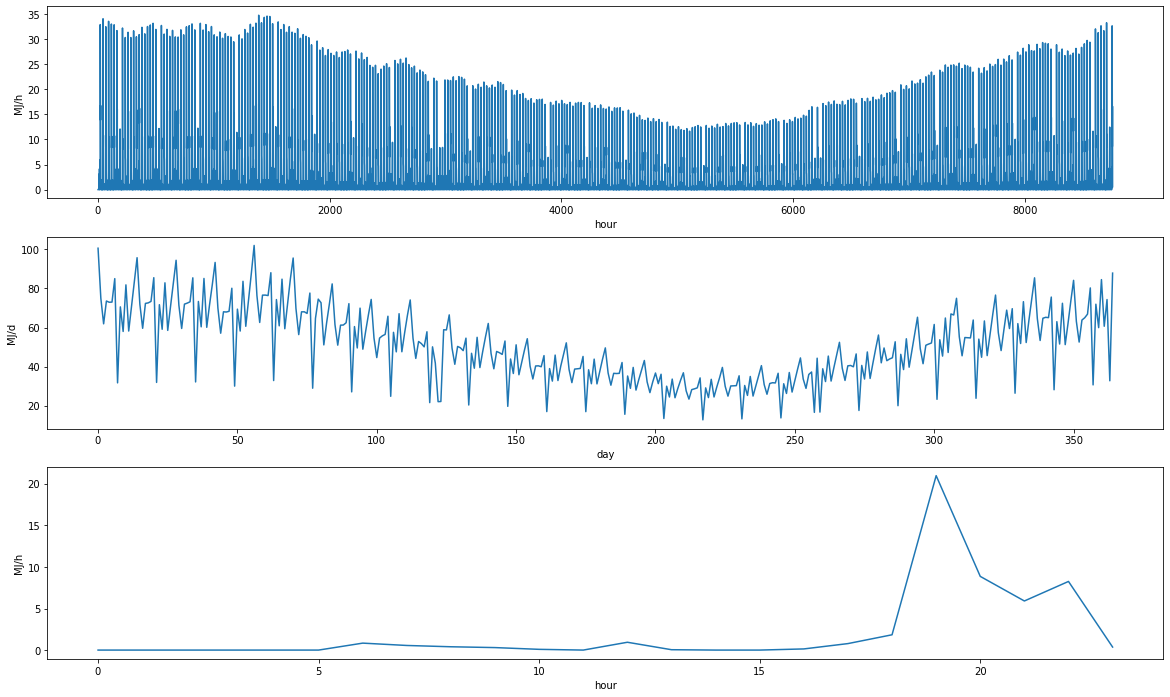

In [31]:
get_each_graph(testcase1)

### 計算条件2

In [32]:
# 計算条件2（石油従来型の場合）

spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '石油潜熱回収型給湯機', 'e_rtd' : 0.819, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase2 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 18715.893892301876MJ/年


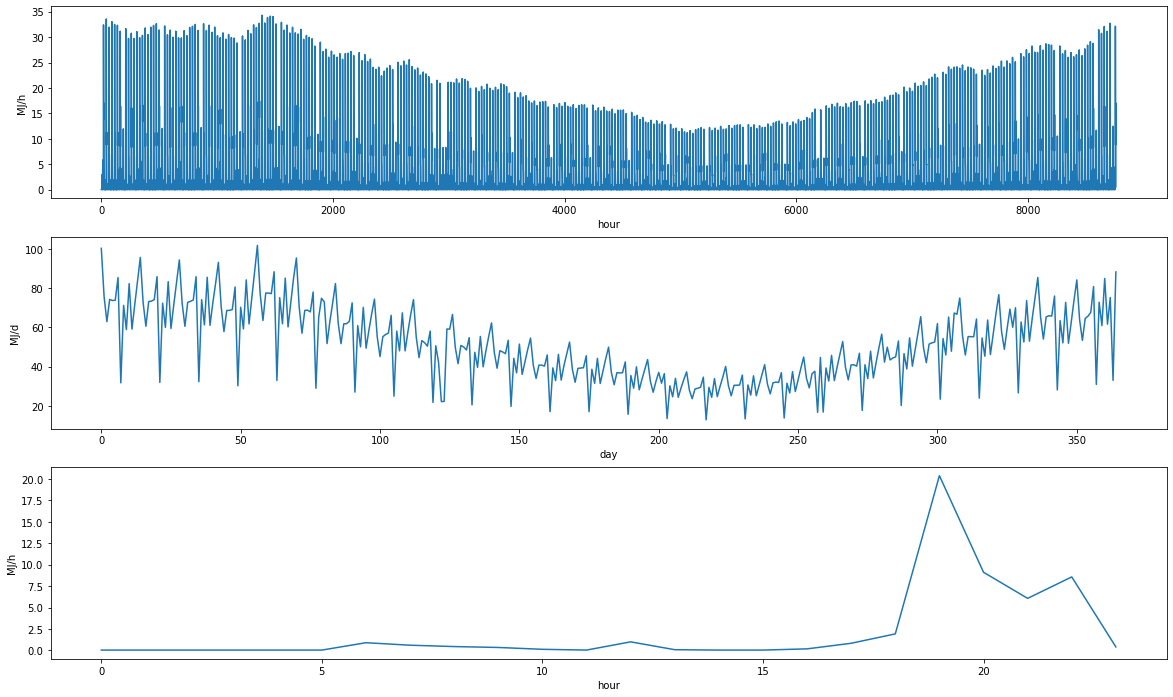

In [33]:
get_each_graph(testcase2)

### 計算条件3

In [34]:
# 計算条件3（電気ヒーター給湯機の場合）

spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '電気ヒーター給湯機', 'e_rtd' : None, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase3 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 49216.01414776801MJ/年


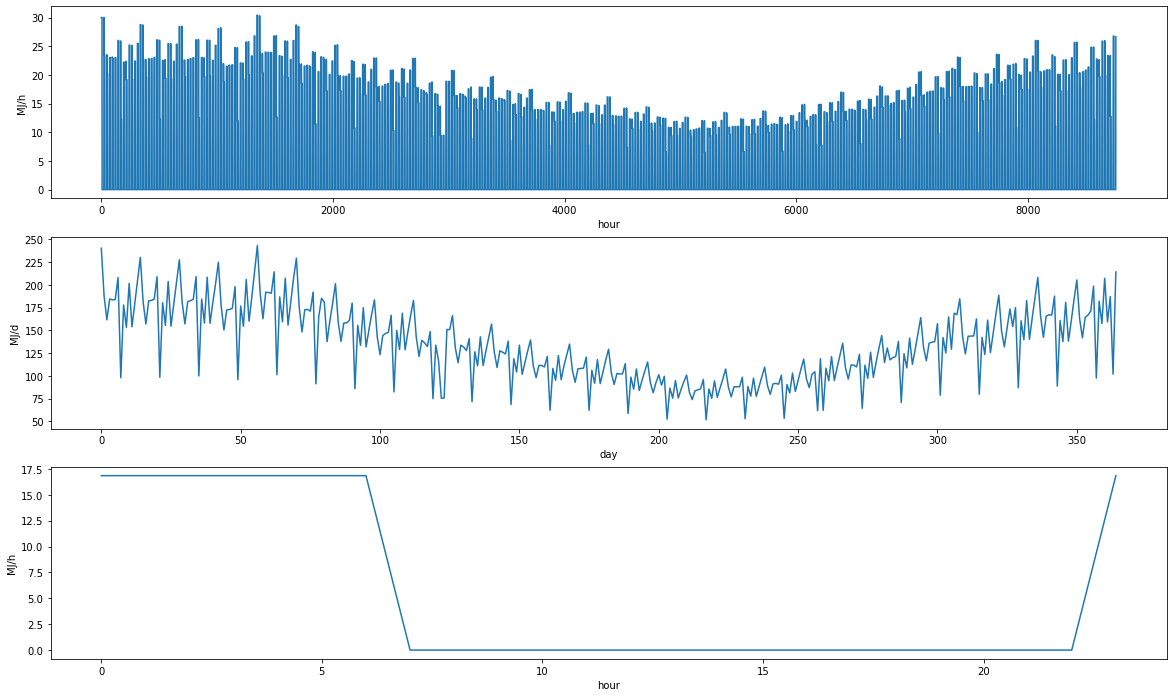

In [35]:
get_each_graph(testcase3)

### 計算条件4

In [36]:
# 計算条件4（HP給湯機の場合）

spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '電気ヒートポンプ給湯機', 'e_rtd' : 2.7, 'e_dash_rtd' : None,
         'hybrid_category' : None, 'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase4 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 17584.747292023356MJ/年


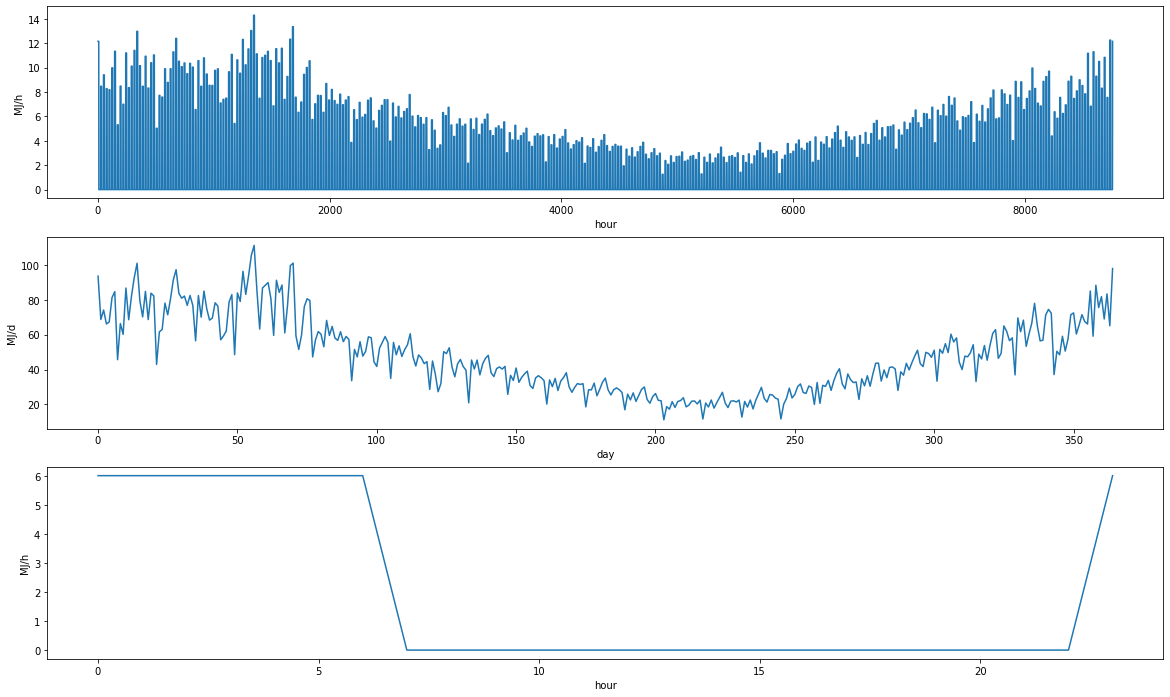

In [37]:
get_each_graph(testcase4)

### 計算条件5

In [38]:
# 計算条件5（シングルHYB給湯機（仕様）の場合）

spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)',
         'e_rtd' : None, 'e_dash_rtd' : None, 'hybrid_category' : '区分3', 'bath_function' : 'ふろ給湯機(追焚あり)',
         'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase5 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 13370.156062314MJ/年


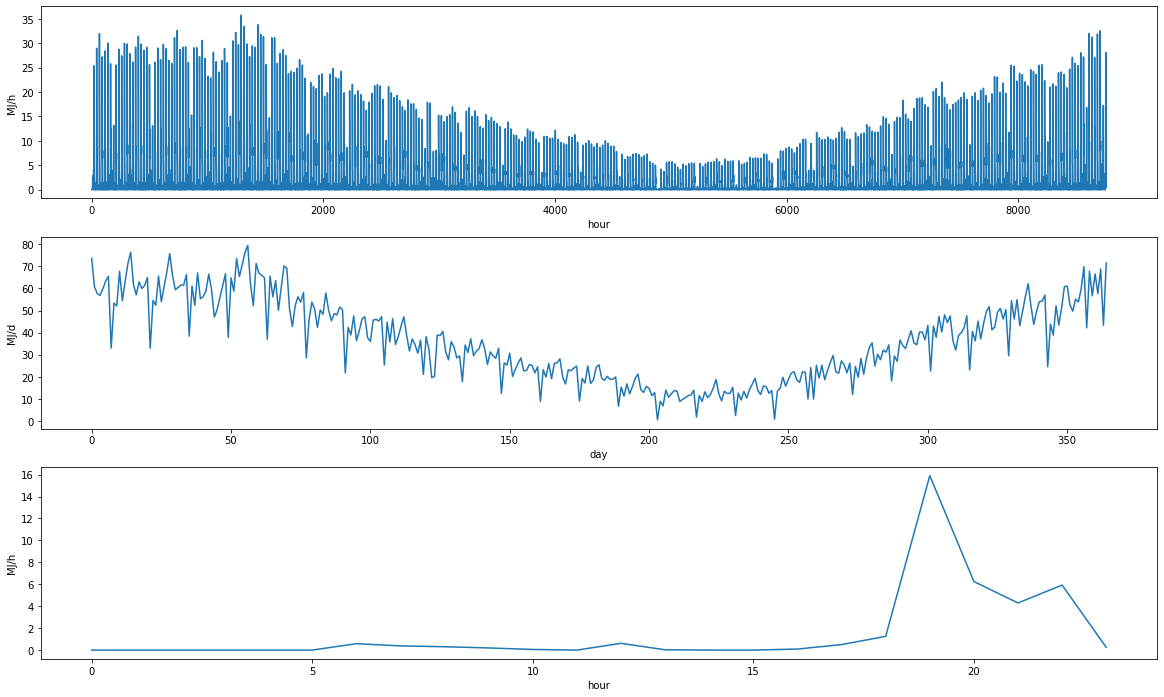

In [39]:
get_each_graph(testcase5)

### 計算条件6

In [40]:
# 計算条件6（シングルHYB給湯機（試験）の場合）

spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(試験された値を用いる)',
         'e_rtd' : None, 'e_dash_rtd' : None, 'hybrid_category' : None, 'package_id' : 2, 'bath_function' : 'ふろ給湯機(追焚あり)',
         'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase6 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 11886.968050605932MJ/年


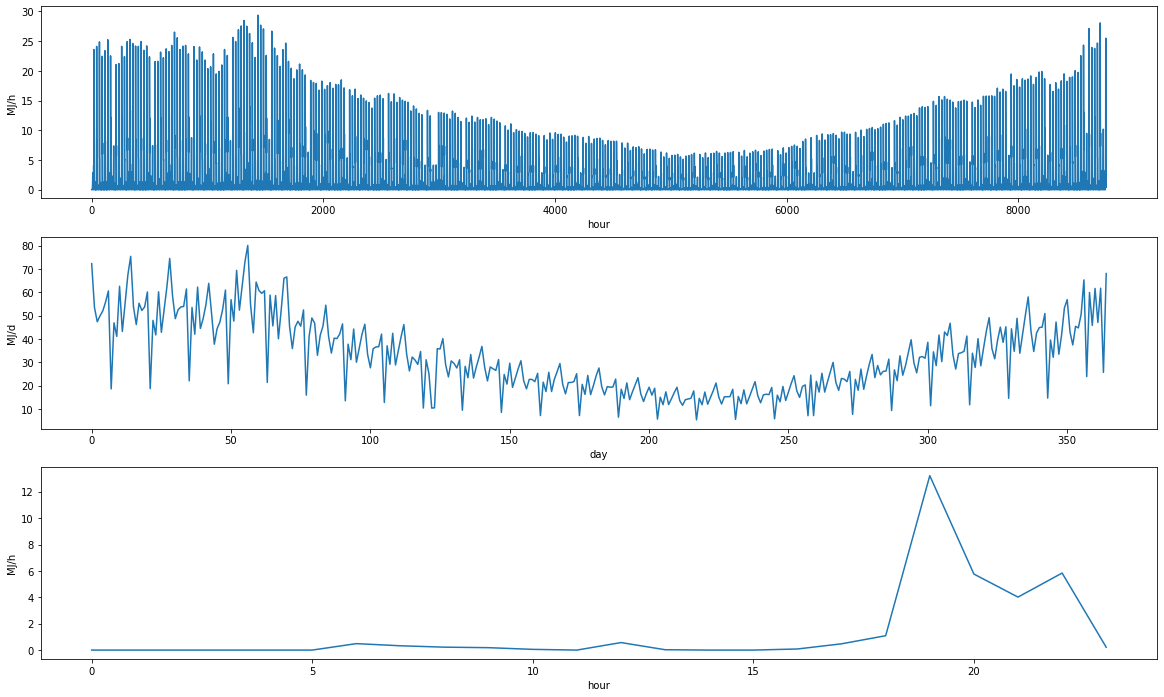

In [41]:
get_each_graph(testcase6)

### 計算条件7

In [42]:
# 計算条件7（シングルHYB暖房機の場合）

spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)',
         'e_rtd' : None, 'e_dash_rtd' : None, 'hybrid_category' : None, 'bath_function' : 'ふろ給湯機(追焚あり)',
         'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase7 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 17992.364492979512MJ/年


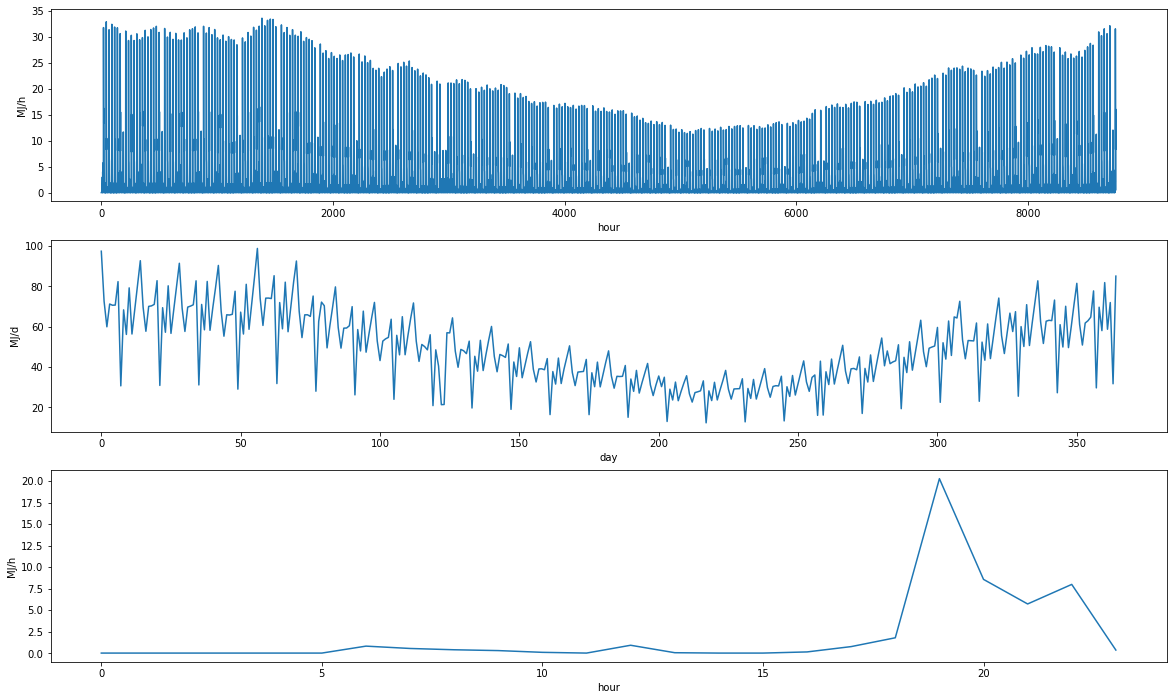

In [43]:
get_each_graph(testcase7)

### 計算条件8

In [44]:
# 計算条件8（ダブルHYB給湯機の場合）

spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : np.zeros(365), 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)',
         'e_rtd' : None, 'e_dash_rtd' : None, 'hybrid_category' : '区分2', 'bath_function' : 'ふろ給湯機(追焚あり)',
         'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase8 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 10568.894153954016MJ/年


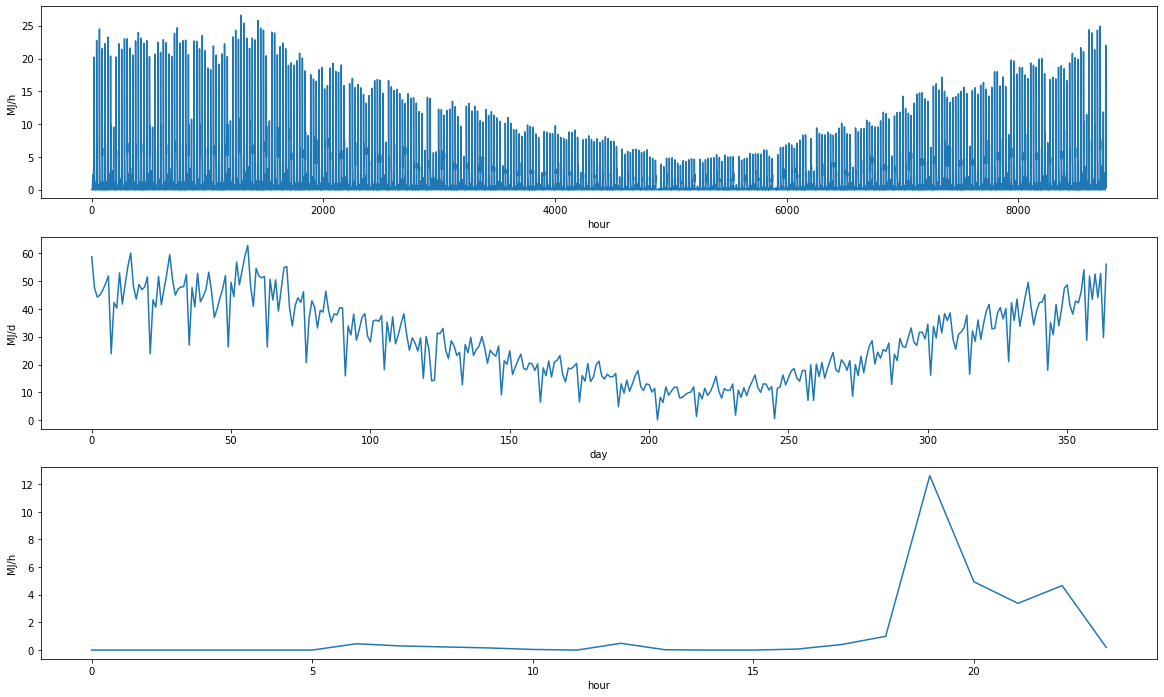

In [45]:
get_each_graph(testcase8)

### 計算条件9

In [46]:
spec = {'region' : 6, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC' : None        
       }

testcase9 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 23685.97691330349MJ/年


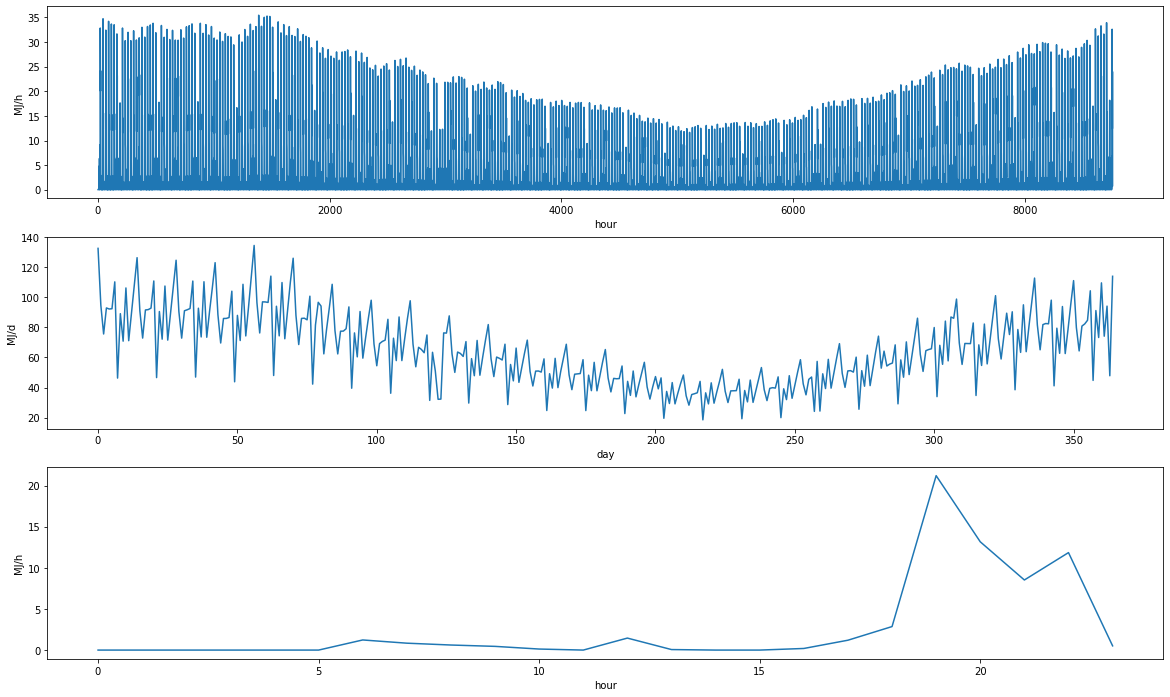

In [47]:
get_each_graph(testcase9)

### 計算条件10

In [48]:
spec = {'region' : 6, 'sol_region' : None, 'A_A' : 90, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC' : None        
       }

testcase10 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 21032.774258372094MJ/年


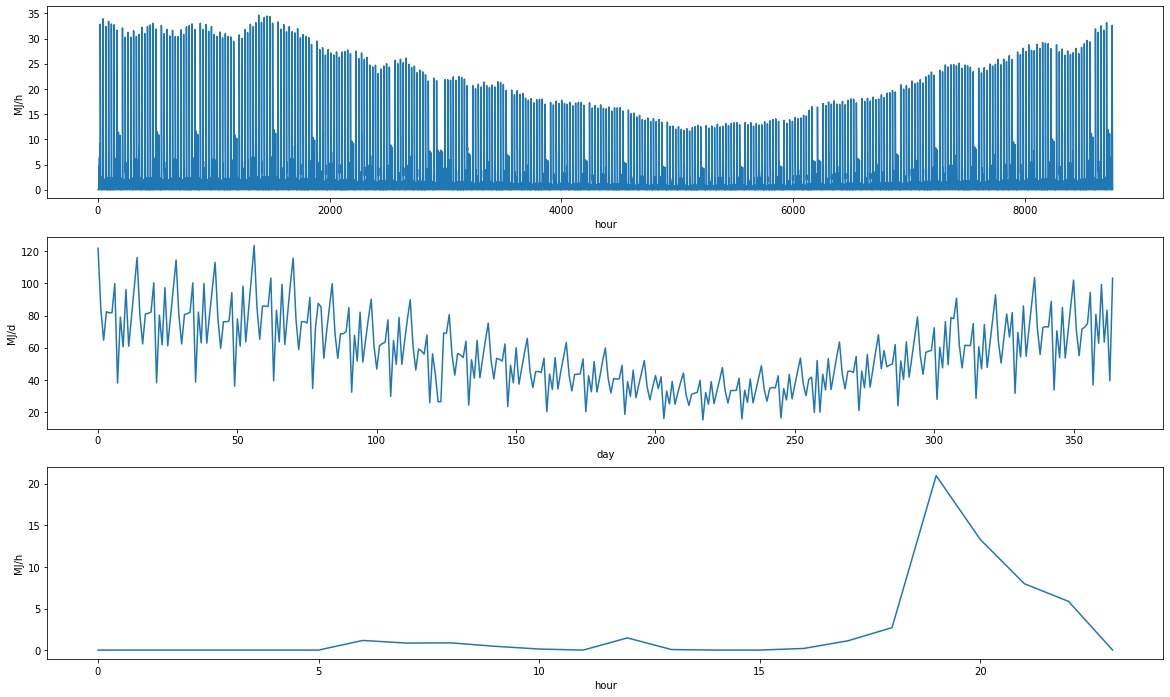

In [49]:
get_each_graph(testcase10)

### 計算条件11

In [50]:
spec = {'region' : 6, 'sol_region' : None, 'A_A' : 60, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC' : None        
       }

testcase11 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 13981.23451117893MJ/年


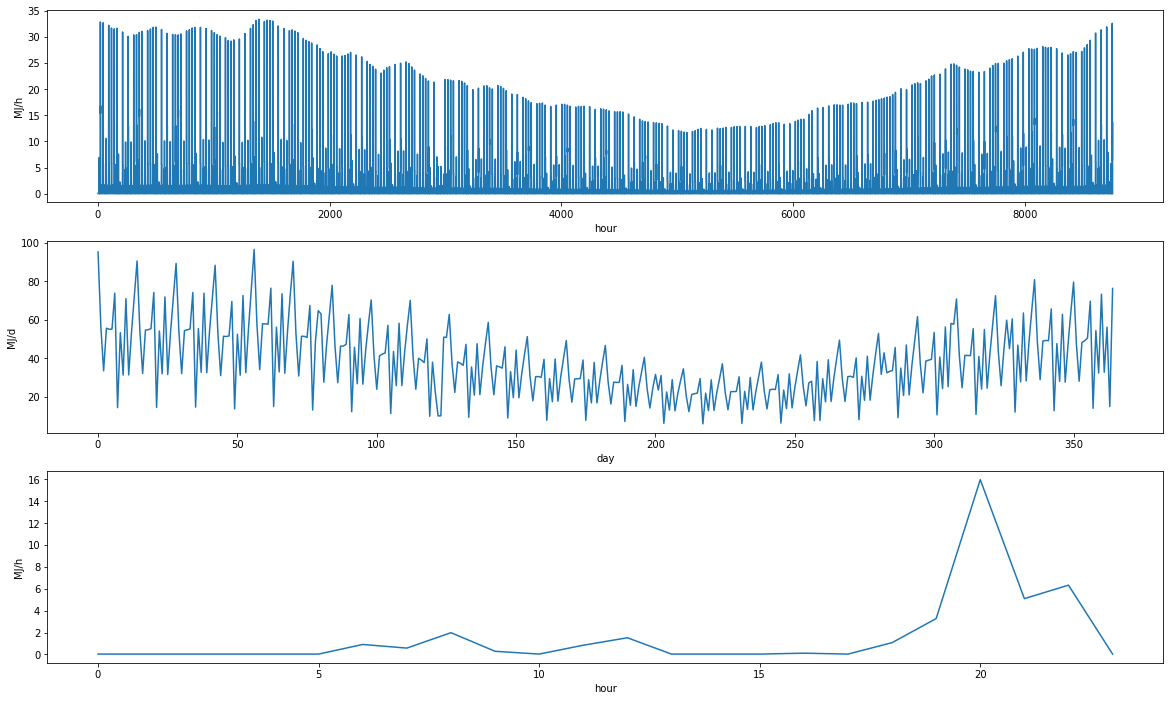

In [51]:
get_each_graph(testcase11)

### 計算条件12

In [52]:
spec = {'region' : 6, 'sol_region' : None, 'A_A' : 30, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC' : None        
       }

testcase12 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 8882.362851622958MJ/年


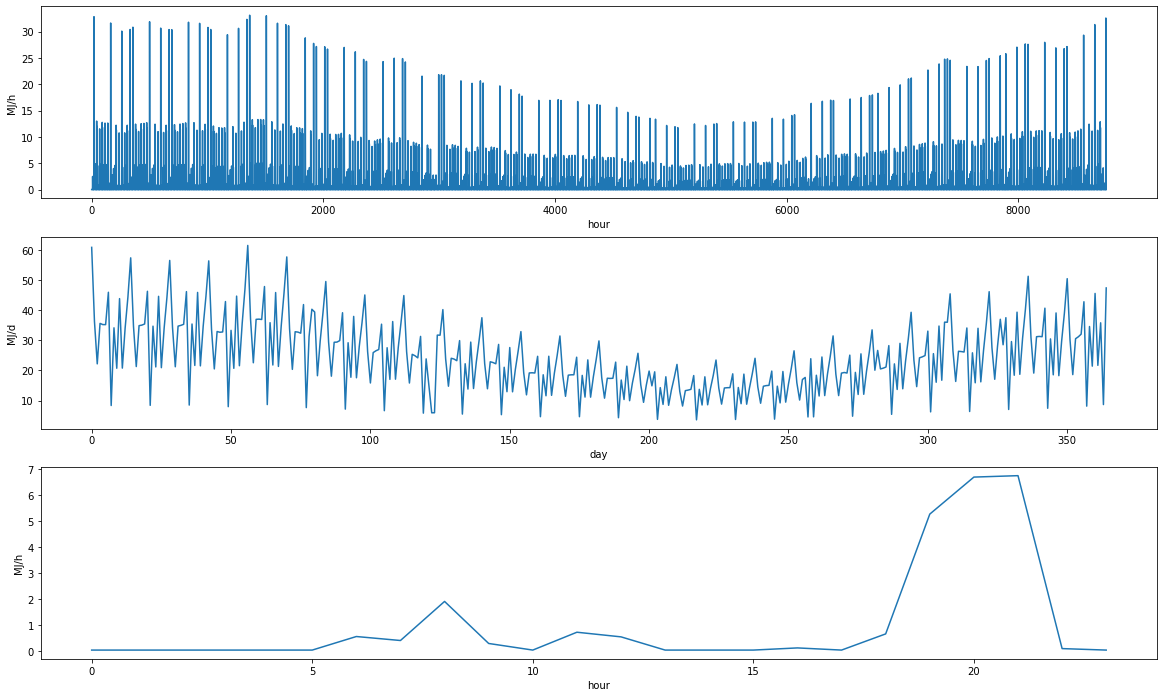

In [53]:
get_each_graph(testcase12)

### 計算条件13

In [54]:
spec = {'region' : 2, 'sol_region' : None, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None, 
         'HW' : {'hw_type' : '電気ヒートポンプ給湯機', 'e_rtd' : 2.7, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : True, 'kitchen_watersaving_C' : True,  'shower_watersaving_A' : True,
         'shower_watersaving_B' : True, 'washbowl_watersaving_C' : True, 'bath_insulation' : True},
         'SHC' : None        
       }

testcase13 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 25634.681115621363MJ/年


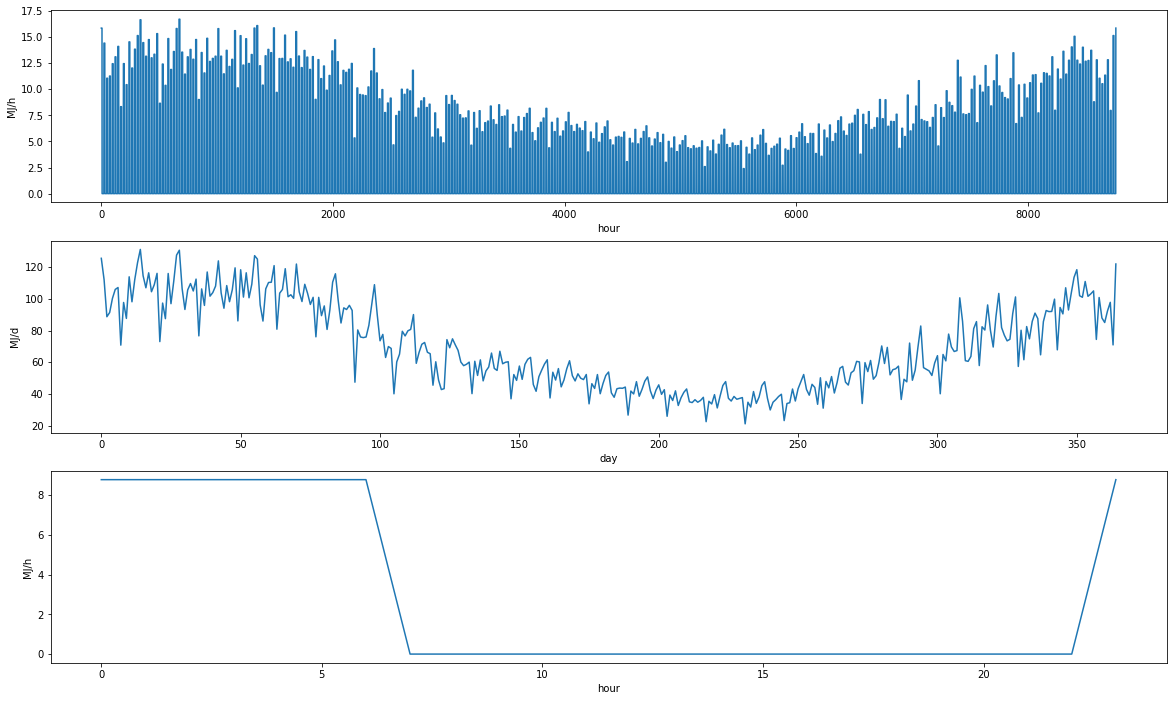

In [55]:
get_each_graph(testcase13)

### 計算条件14

In [56]:
spec = {'region' : 6, 'sol_region' : 3, 'A_A' : 120.08, 'L_HWH' : None, 'heating_flag_d' : None,
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC' : {'type' : '液体集熱式', 'A_sp' : 5, 'P_alpha_sp' : 330, 'P_beta_sp' : 30,
                  'ls_type' : '太陽熱温水器', 'W_tnk_ss': None}
       }


testcase14 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 16062.423896870116MJ/年


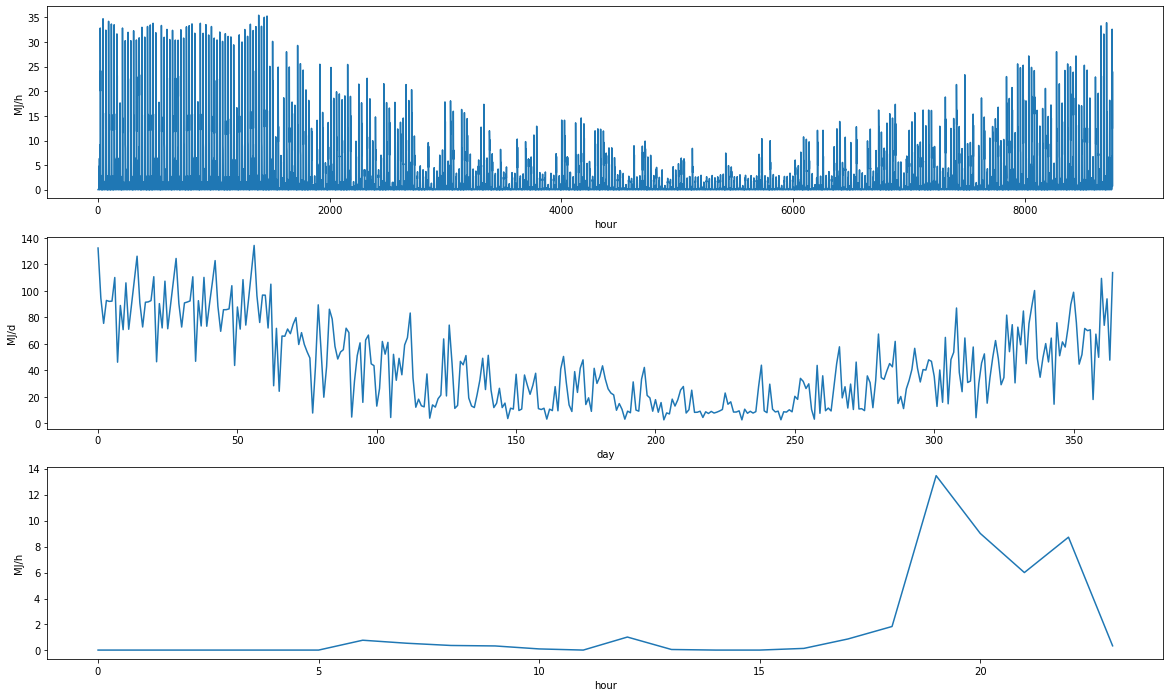

In [57]:
get_each_graph(testcase14)

### 計算条件15

In [58]:
spec = {'region' : 6, 'sol_region' : 3, 'A_A' : 120, 'L_HWH' : None, 'heating_flag_d' : None,
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC' : {'type' : '液体集熱式', 'A_sp' : 5, 'P_alpha_sp' : 330, 'P_beta_sp' : 30,
                  'ls_type' : 'ソーラーシステム', 'W_tnk_ss' : 100}
       }

testcase15 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 18399.09687620763MJ/年


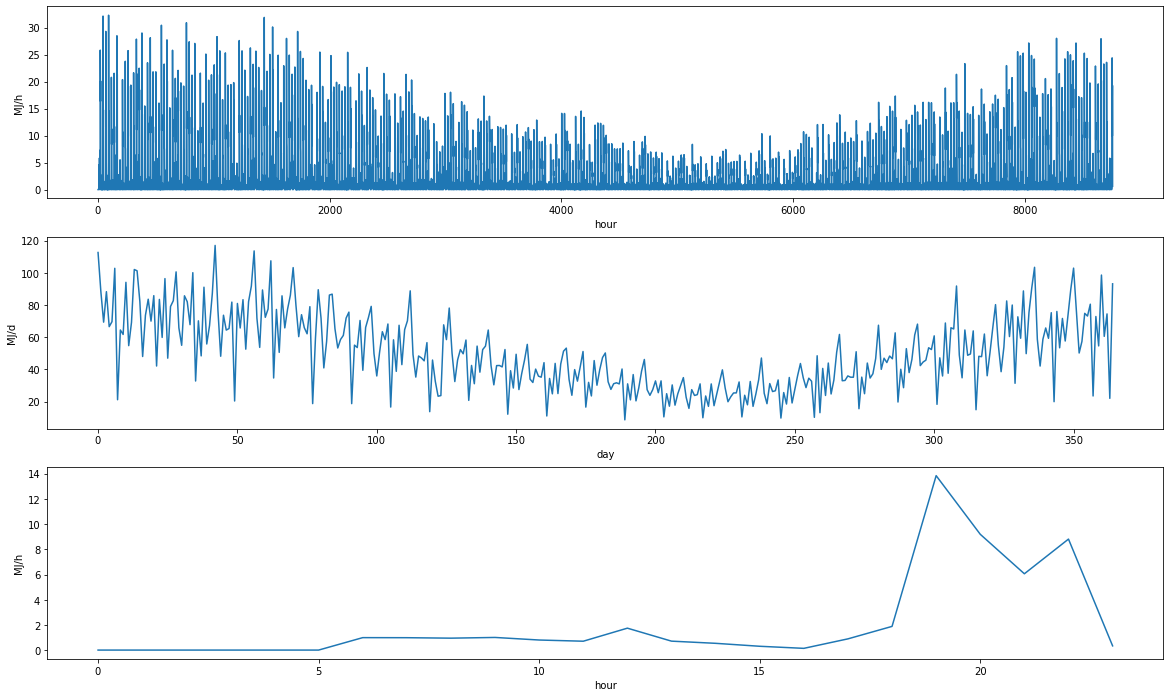

In [59]:
get_each_graph(testcase15)

### 計算条件16

In [60]:
spec = {'region' : 6, 'sol_region' : 3, 'A_A' : 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51,
        "U_A":0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'L_HWH' : None,
        "H_MR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False},
        "H_OR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False},
        'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC': {'type': '空気集熱式', 'P_alpha': 330, 'fan_sso': False, 'fan_type': 'AC', 'hotwater_use': False,
                 'pump_sso': False, 'W_tnk_ass': None, 'V_fan_P0': 300, 'A_col': (3, 5), 'P_beta': (30, 50), 'd0': (0.1, 0.2),
                 'd1': (2.0, 2.2), 'm_fan_test': (0.0107, 0.014), 'supply_target': '居室', 'r_A_ufvnt_ass': None, 'ufv_insulation': None}
       }

testcase16 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 23685.97691330349MJ/年


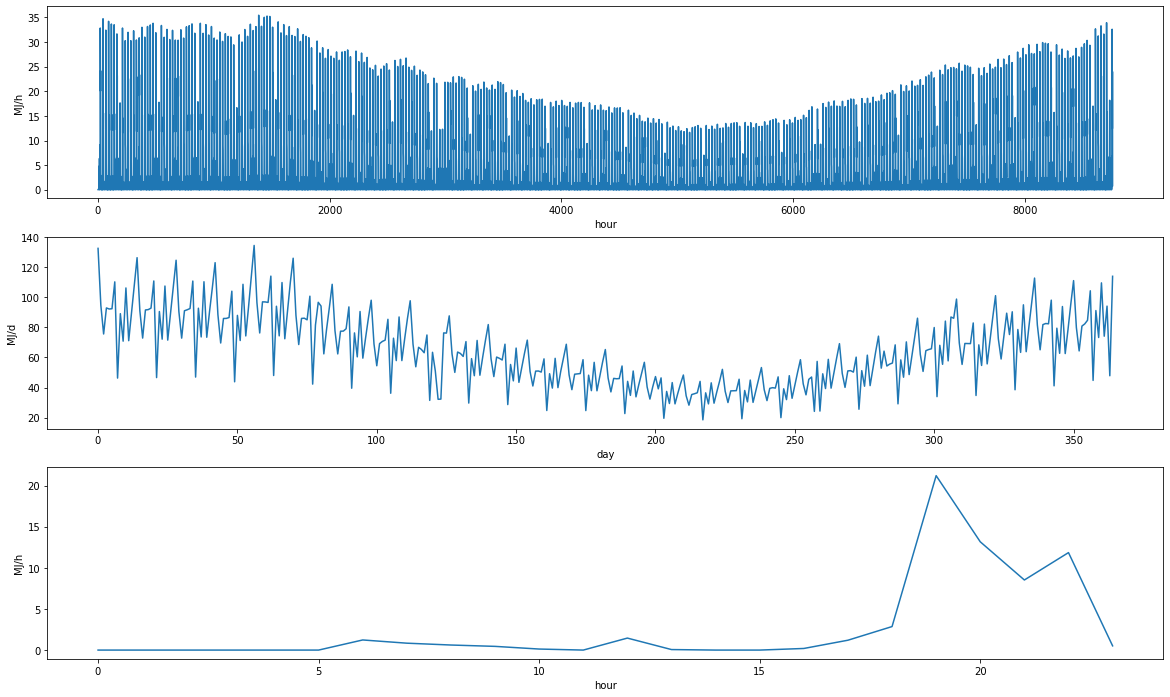

In [61]:
get_each_graph(testcase16)

### 計算条件17

In [62]:
spec = {'region' : 6, 'sol_region' : 3, 'A_A' : 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51,
        "U_A":0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'L_HWH' : None,
        "H_MR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False},
        "H_OR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False},
         'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC': {'type': '空気集熱式', 'P_alpha': 330, 'fan_sso': False, 'fan_type': 'AC', 'hotwater_use': True,
                 'pump_sso': False, 'W_tnk_ass': 100, 'V_fan_P0': 300, 'A_col': (3, 5), 'P_beta': (30, 50), 'd0': (0.1, 0.2),
                 'd1': (2.0, 2.2), 'm_fan_test': (0.0107, 0.014), 'supply_target': '居室', 'r_A_ufvnt_ass': None, 'ufv_insulation': None}
       }

testcase17 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 26059.134559302325MJ/年


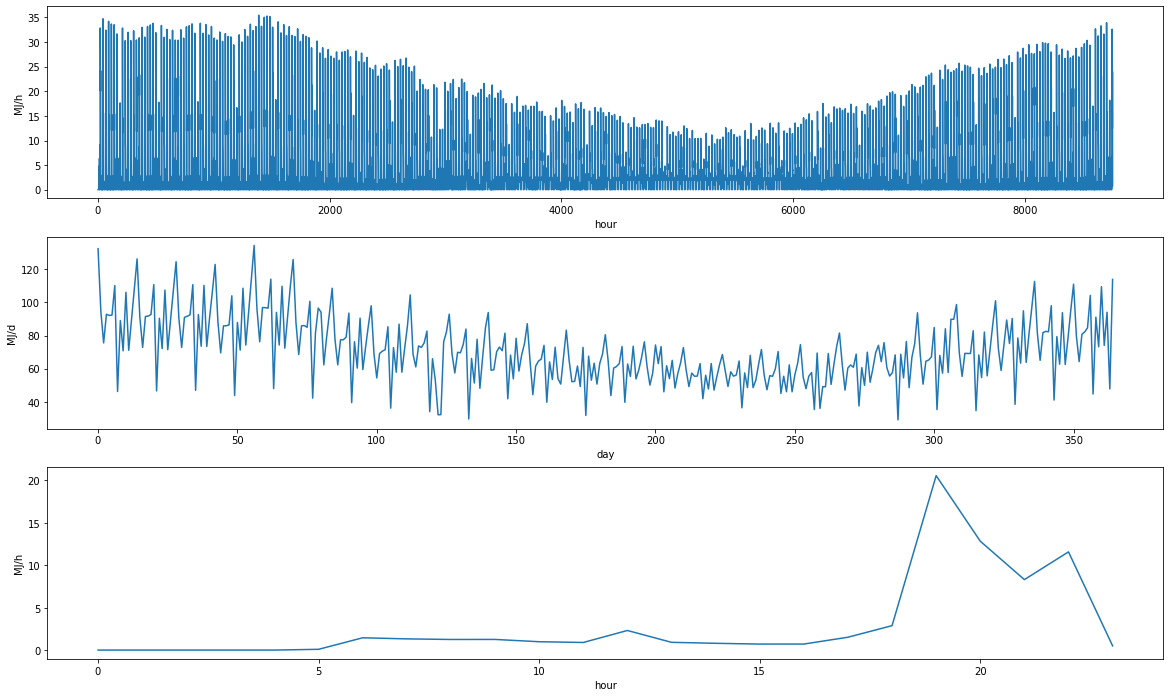

In [63]:
get_each_graph(testcase17)

### 計算条件18

In [64]:
spec = {'region' : 6, 'sol_region' : 3, 'A_A' : 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51,
        "U_A":0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'L_HWH' : None,
        "H_MR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False},
        "H_OR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False},
        'HW' : {'hw_type' : 'ガス潜熱回収型給湯機', 'e_rtd' : 0.836, 'e_dash_rtd' : None, 'hybrid_category' : None,
         'bath_function' : 'ふろ給湯機(追焚あり)', 'has_bath' : True, 'pipe_diameter' : '上記以外',
         'kitchen_watersaving_A' : False, 'kitchen_watersaving_C' : False,  'shower_watersaving_A' : False,
         'shower_watersaving_B' : False, 'washbowl_watersaving_C' : False, 'bath_insulation' : False},
         'SHC': {'type': '空気集熱式', 'P_alpha': 330, 'fan_sso': False, 'fan_type': 'AC', 'hotwater_use': False,
                 'pump_sso': False, 'W_tnk_ass': None, 'V_fan_P0': 300, 'A_col': (3, 5), 'P_beta': (30, 50), 'd0': (0.1, 0.2),
                 'd1': (2.0, 2.2), 'm_fan_test': (0.0107, 0.014), 'supply_target': '床下', 'r_A_ufvnt_ass': 0.8, 'ufv_insulation': True}
       }

testcase18 = calc_results(spec)['Ene_TOTAL']

給湯用一次エネルギー消費量 = 23685.97691330349MJ/年


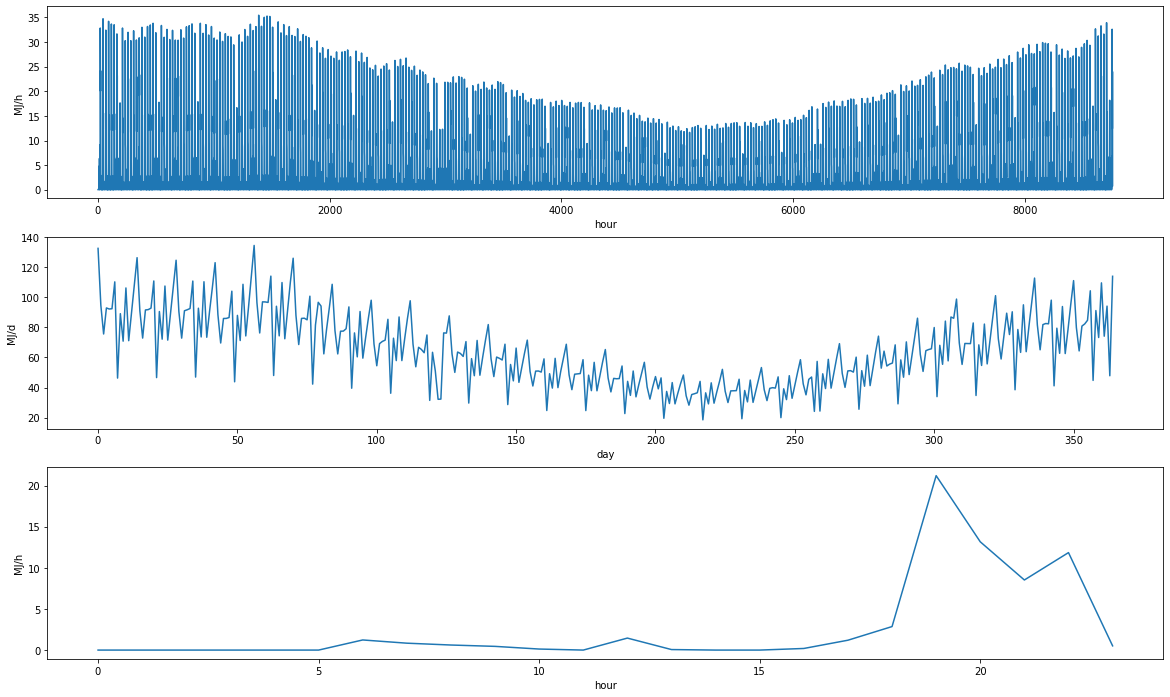

In [65]:
get_each_graph(testcase18)

### 比較

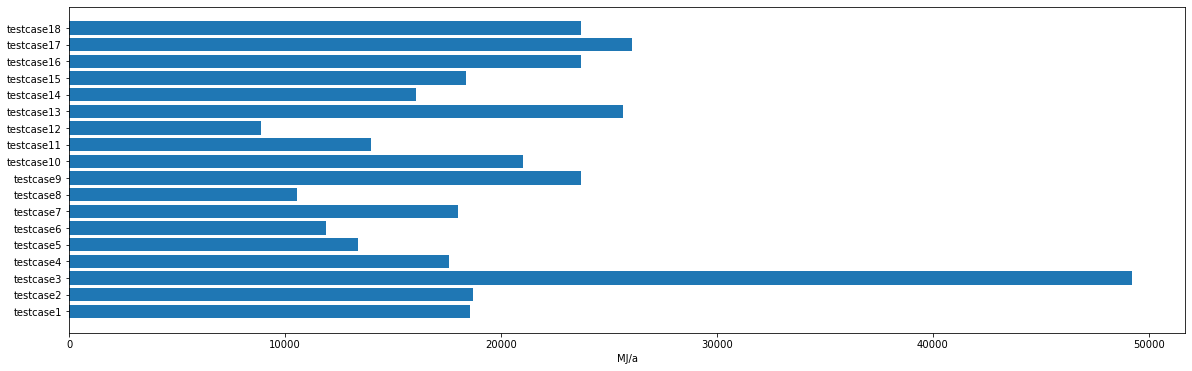

In [66]:
dat = {"testcase1":sum(testcase1),"testcase2" : sum(testcase2), "testcase3" : sum(testcase3), "testcase4" : sum(testcase4), 
       "testcase5" : sum(testcase5), "testcase6" : sum(testcase6), "testcase7" : sum(testcase7), "testcase8" : sum(testcase8),
       "testcase9" : sum(testcase9), "testcase10" : sum(testcase10), "testcase11" : sum(testcase11), "testcase12" : sum(testcase12),
       "testcase13" : sum(testcase13), "testcase14" : sum(testcase14), "testcase15" : sum(testcase15), "testcase16" : sum(testcase16),
       "testcase17" : sum(testcase17), "testcase18" : sum(testcase18)}
xx = list(dat.keys())
yy = list(dat.values())

fig = plt.figure(figsize=(20,6))
axt = fig.add_subplot(111)
axt.barh(xx,yy)
axt.set_xlabel("MJ/a")
plt.show()
